# Д/З 2.1: построение сетей CNN + FFN
### Выполнила Елизавета Клыкова, БКЛ181
#### Импорт библиотек

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import re
import random
import numpy as np
import pandas as pd
from nltk import word_tokenize
from collections import Counter
from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, \
    RandomSampler, SequentialSampler
from torchmetrics import F1
from torchmetrics.functional import f1, recall

In [3]:
seed = 117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available()\
                              else torch.device('cpu')
DEVICE

device(type='cuda')

#### Загрузка [датасета](http://study.mokoron.com/)

- **id**: уникальный номер сообщения в системе twitter;
- **tdate**: дата публикации сообщения (твита);
- **tname**: имя пользователя, опубликовавшего сообщение;
- **ttext**:  текст сообщения (твита);
- **ttype**: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
- **trep**: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
- **tfav**: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
- **tstcount**: число всех сообщений пользователя в сети twitter;
- **tfol**: количество фоловеров пользователя (тех людей, которые читают пользователя);
- **tfrien**: количество друзей пользователя (те люди, которых читает пользователь);
- **listcount**: количество листов-подписок в которые добавлен твиттер-пользователь.

In [5]:
cols = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw',
        'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

pos = pd.read_csv('positive.csv', sep=';', names=cols)
neg = pd.read_csv('negative.csv', sep=';', names=cols)
neg['ttype'] = 0

pos.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [6]:
tweets = pos.append(neg)[['ttext', 'ttype']]
len(tweets[tweets.duplicated()])

9394

In [7]:
tweets[tweets.duplicated()].sort_values('ttext')

,ttext,ttype
52816,""" Голос"" в этом году-неожиданно заинтриговал в...",0
73351,"""..и тогда наверняка,вдруг запляшут облака и к...",0
66733,"""..и тогда наверняка,вдруг запляшут облака и к...",0
37093,"""The libxml library also has a SAX-like interf...",1
83828,"""The libxml library also has a SAX-like interf...",1
...,...,...
24266,— президенты тоже люди:-) но в этот раз без ор...,1
37142,— президенты тоже люди:-) но в этот раз без ор...,1
29399,— сей музлоплеер требует Java и... mplayer O_o,0
94621,“@AsyaOmarova: Ах да .. С днем главной книгой ...,1


In [8]:
tweets.drop_duplicates(inplace=True)
tweets.reset_index(drop=True, inplace=True)
tweets

,ttext,ttype
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
217435,Но не каждый хочет что то исправлять:( http://...,0
217436,скучаю так :-( только @taaannyaaa вправляет мо...,0
217437,"Вот и в школу, в говно это идти уже надо(",0
217438,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


In [9]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub(r'@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    tokens = [t for t in word_tokenize(text.strip()) if t]
    return tokens

In [10]:
prep_texts = []
unique_tokens = Counter()

for text in tqdm(tweets['ttext']):
    tokens = preprocess_text(text)
    unique_tokens.update(tokens)
    prep_texts.append(tokens)

print('Всего уникальных токенов:', len(unique_tokens))

  0%|          | 0/217440 [00:00<?, ?it/s]

Всего уникальных токенов: 180371


In [11]:
tweets['tokens'] = prep_texts

In [12]:
tweets.to_csv('final_tweets_dataset.tsv', sep='\t', index=False)

#### Словари для модели

In [13]:
token2id = {'PAD': 0}

for token, freq in unique_tokens.most_common():
    if freq >= 5:
        token2id[token] = len(token2id)

In [14]:
id2token = {i: token for token, i in token2id.items()}
len(id2token.values())

31175

## Часть 1: CNN на уровне слов

Решите задачу, используя две следующие архитектуры. Для каждой посчитайте accuracy, precision, recall.

**I. CNN на уровне слов:** модель берет слова, пропускает их через Embedding слой. По эмбеддингам проходит CNN c фильтрами с разным окном, полученные результаты конкатенируются друг с другом по глубине, по результату конкатенации еще один сверточный слой, далее max pooling over time, на выходе линейный слой + сигмоида, функция потерь BCELoss. (Модель аналогична тому, что мы делали на паре по сверткам, но на уровне слов, а не символов.)

**Баллы:**

1. Embedding слой обучается внутри первой модели -- 1 балл

2. Подгружаются обученные эмбеддинги для русского языка или fasttext эмбеддинги обучаются на всем корпусе с нуля и далее подгружаются в модель -- 1 балл

3. Первая модель правильно построена и обучается -- 1 балл

4. Для первой модели показано, что качество можно улучшить засчет работы с гиперпараметрами и/или доведения архитектуры (помогло изменение количества/размера фильтров, размера слоя/эмбеддингов, добавили Dropout и спаслись от переобучения, добавили слоев и т.д.) -- 1 балл

### Dataset & DataLoader

In [15]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, token2id, DEVICE):
        self.dataset = dataset['tokens'].values
        self.target = dataset['ttype'].values
        self.length = dataset.shape[0]
        self.token2id = token2id
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        tokens = self.dataset[index]
        ids = torch.LongTensor([self.token2id[token] for token in tokens
                                if token in self.token2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        # этот метод можно реализовывать и отдельно,
        # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [16]:
train_data, val_data = train_test_split(tweets, test_size=0.2,
                                        random_state=seed,
                                        stratify=tweets['ttype'])

In [17]:
train_dataset = TweetsDataset(train_data, token2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset,
                            collate_fn=train_dataset.collate_fn,
                            sampler=train_sampler, batch_size=1024)

In [18]:
val_dataset = TweetsDataset(val_data, token2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset,
                          collate_fn=val_dataset.collate_fn,
                          sampler=val_sampler, batch_size=1024)

### CNN-модель
(Модель аналогична тому, что мы делали на паре по сверткам, но на уровне слов, а не символов.)

* Модель берет слова, пропускает их через Embedding слой
* По эмбеддингам проходит CNN c фильтрами с разным окном
* Полученные результаты конкатенируются друг с другом по глубине
* По результату конкатенации еще один сверточный слой
* Далее max pooling over time
* На выходе линейный слой + сигмоида
* Функция потерь BCELoss

Сразу добавляем параметр, позволяющий использовать предобученные эмбеддинги.

In [19]:
class CNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim, weights=None):
        super().__init__()
        # эмбеддинг-слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if weights is not None:
            self.embedding.from_pretrained(torch.tensor(weights),
                                           freeze=True)
        # биграммная свертка
        self.bigrams = nn.Conv1d(in_channels=embedding_dim,
                                 out_channels=100, kernel_size=2,
                                 padding='same')
        # триграммная свертка
        self.trigrams = nn.Conv1d(in_channels=embedding_dim,
                                  out_channels=80, kernel_size=3,
                                  padding='same')
        # еще одна биграммная свертка по результатам конкатенации
        self.bigrams_concat = nn.Conv1d(in_channels=180,
                                        out_channels=100,
                                        kernel_size=2,
                                        padding='same')
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        # было batch_size x seq_len

        # batch_size x seq_len x embedding_dim
        embedded = self.embedding(word)
        # batch_size x embedding_dim x seq_len
        embedded = embedded.transpose(1, 2)

        # batch_size x filter_count2 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.relu(self.bigrams_concat(concat))

        pooling = feature_map_concat.max(2)[0]
        logits = self.hidden(pooling)
        logits = self.out(logits)

        return logits

In [20]:
def train(model, iterator, optimizer, criterion, n_epoch):

    progress_bar = tqdm(total=len(train_iterator.dataset),
                        desc='Epoch {}'.format(n_epoch + 1))

    epoch_losses = []  # для подсчета среднего лосса на всех батчах
    epoch_metrics = []
    model.train()  # ставим модель в обучение

    for i, (texts, ys) in enumerate(iterator):  # итерируемся по батчам

        optimizer.zero_grad()  # обнуляем градиенты
        preds = model(texts)  # прогоняем данные через модель
        loss = criterion(preds, ys)  # считаем значение функции потерь
        loss.backward()  # считаем градиенты
        optimizer.step()  # обновляем веса

        # сохраняем значения лосс и f1
        epoch_losses.append(loss.item())
        batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metrics.append(batch_metric.cpu().numpy())

        if (i + 1) % int(len(iterator) / 5) == 0:
            print('Train loss: {}, Train f1: {}'.format(
                np.mean(epoch_losses), np.mean(epoch_metrics)))

        progress_bar.update(texts.shape[0])

    progress_bar.close()

    # возвращаем список (потом построим график и посчитаем среднее)
    return epoch_losses, epoch_metrics

In [21]:
def evaluate(model, iterator, criterion, n_epoch):

    epoch_losses = []
    epoch_metrics = []
    model.eval()

    with torch.no_grad():

        for i, (texts, ys) in enumerate(iterator):
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)  # считаем значения лосса

            # сохраняем значения лосса и f1
            epoch_losses.append(loss.item())
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metrics.append(batch_metric.cpu().numpy())

            if (i + 1) % int(len(iterator) / 5) == 0:
                print('Val loss: {}, Val f1: {}'.format(
                    np.mean(epoch_losses), np.mean(epoch_metrics)))

    # возвращаем список (потом построим график и посчитаем среднее)
    return epoch_losses, epoch_metrics

In [22]:
def train_and_evaluate(model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=5):
    losses_train = []
    f1s_train = []
    losses_eval = []
    f1s_eval = []

    for n_epoch in range(epochs):

        print('\nTraining...')
        train_losses, train_f1s = train(model, train_iterator,
                                        optimizer, criterion, n_epoch)
        losses_train.append(train_losses)
        f1s_train.append(train_f1s)

        print('\nValidating...\n')
        test_losses, test_f1s = evaluate(model, val_iterator,
                                         criterion, n_epoch)
        losses_eval.append(test_losses)
        f1s_eval.append(test_f1s)

    return losses_train, losses_eval, f1s_train, f1s_eval

In [23]:
cnn_model = CNN(len(token2id), 100)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
cnn_model = cnn_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [24]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(cnn_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


Train loss: 0.6560101509094238, Train f1: 0.6219015717506409
Train loss: 0.6281143216525807, Train f1: 0.6350855827331543
Train loss: 0.6121825564141367, Train f1: 0.6464799046516418
Train loss: 0.6015132284339737, Train f1: 0.6556743383407593
Train loss: 0.5933347575804766, Train f1: 0.6617342829704285

Validating...

Val loss: 0.5510078966617584, Val f1: 0.6967521905899048
Val loss: 0.552347969263792, Val f1: 0.6958134770393372
Val loss: 0.5537596171100935, Val f1: 0.6932012438774109
Val loss: 0.5542488619685173, Val f1: 0.6903665661811829
Val loss: 0.5546848237514496, Val f1: 0.6899035573005676

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5415269364328945, Train f1: 0.7109090089797974
Train loss: 0.538500255521606, Train f1: 0.7144717574119568
Train loss: 0.5351455030488033, Train f1: 0.7173916101455688
Train loss: 0.5329080090364989, Train f1: 0.7192038893699646
Train loss: 0.5306574160561842, Train f1: 0.7204596996307373

Validating...

Val loss: 0.5221298336982727, Val f1: 0.7440990209579468
Val loss: 0.5237428210675716, Val f1: 0.7420331239700317
Val loss: 0.5256565436720848, Val f1: 0.740168571472168
Val loss: 0.5256096590310335, Val f1: 0.739326000213623
Val loss: 0.5263884484767913, Val f1: 0.7393321990966797

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5022990905186709, Train f1: 0.7436736226081848
Train loss: 0.5016367321505266, Train f1: 0.7468695640563965
Train loss: 0.49958284754379123, Train f1: 0.7481335401535034
Train loss: 0.4973592758178711, Train f1: 0.7499875426292419
Train loss: 0.4952187040272881, Train f1: 0.7517410516738892

Validating...

Val loss: 0.5058846436440945, Val f1: 0.7251939177513123
Val loss: 0.5060822293162346, Val f1: 0.7252129316329956
Val loss: 0.508527455230554, Val f1: 0.722567081451416
Val loss: 0.5089727602899075, Val f1: 0.7208420038223267
Val loss: 0.5100082345306873, Val f1: 0.7207843065261841

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46842381533454447, Train f1: 0.7723289132118225
Train loss: 0.46921250224113464, Train f1: 0.7702773809432983
Train loss: 0.4661984437820958, Train f1: 0.7737776637077332
Train loss: 0.4663468132562497, Train f1: 0.773845911026001
Train loss: 0.4661300382193397, Train f1: 0.7742777466773987

Validating...

Val loss: 0.49216170608997345, Val f1: 0.7532077431678772
Val loss: 0.49296810105443, Val f1: 0.7497591376304626
Val loss: 0.4948827115197976, Val f1: 0.7467190623283386
Val loss: 0.49489129800349474, Val f1: 0.7466685771942139
Val loss: 0.49653480425477026, Val f1: 0.7459739446640015

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4438231850371641, Train f1: 0.7912641167640686
Train loss: 0.4432397344533135, Train f1: 0.7915349006652832
Train loss: 0.4419766325576633, Train f1: 0.7917447090148926
Train loss: 0.4426240894724341, Train f1: 0.7906659245491028
Train loss: 0.4412705288213842, Train f1: 0.7917878031730652

Validating...

Val loss: 0.4897988438606262, Val f1: 0.7697038054466248
Val loss: 0.4909462723881006, Val f1: 0.7689920663833618
Val loss: 0.4937337450683117, Val f1: 0.7670833468437195
Val loss: 0.49350285064429045, Val f1: 0.7664477229118347
Val loss: 0.49570468440651894, Val f1: 0.7651943564414978

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4189591705799103, Train f1: 0.80750572681427
Train loss: 0.4175643175840378, Train f1: 0.8080177307128906
Train loss: 0.4186687504543978, Train f1: 0.806459367275238
Train loss: 0.4178639540777487, Train f1: 0.8079943656921387
Train loss: 0.4195077980265898, Train f1: 0.8060947060585022

Validating...

Val loss: 0.4810008145868778, Val f1: 0.7632201910018921
Val loss: 0.48242979124188423, Val f1: 0.7621799111366272
Val loss: 0.4855438197652499, Val f1: 0.7603254318237305
Val loss: 0.48614573292434216, Val f1: 0.7590099573135376
Val loss: 0.4882104881107807, Val f1: 0.758100152015686

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.39643799469751473, Train f1: 0.8231334090232849
Train loss: 0.39614303541534085, Train f1: 0.8215896487236023
Train loss: 0.3951220889301861, Train f1: 0.8222789168357849
Train loss: 0.39594319813391743, Train f1: 0.8219960927963257
Train loss: 0.39568833796417013, Train f1: 0.821831226348877

Validating...

Val loss: 0.48305176943540573, Val f1: 0.7732378244400024
Val loss: 0.4864272363483906, Val f1: 0.7697732448577881
Val loss: 0.48967426270246506, Val f1: 0.7667584419250488
Val loss: 0.4893408799543977, Val f1: 0.7658877372741699
Val loss: 0.4919242613017559, Val f1: 0.7655086517333984

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.37757854601916147, Train f1: 0.832831859588623
Train loss: 0.3742114708704107, Train f1: 0.835336446762085
Train loss: 0.3750589454875273, Train f1: 0.8346551060676575
Train loss: 0.37528813367380814, Train f1: 0.8340010046958923
Train loss: 0.3749627872424967, Train f1: 0.8341161608695984

Validating...

Val loss: 0.4884607866406441, Val f1: 0.775025486946106
Val loss: 0.49165972508490086, Val f1: 0.7740914225578308
Val loss: 0.4948105663061142, Val f1: 0.7734621167182922
Val loss: 0.4955889414995909, Val f1: 0.7736632823944092
Val loss: 0.49847185239195824, Val f1: 0.7736424207687378

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.35331446283003864, Train f1: 0.8496757745742798
Train loss: 0.3547674093176337, Train f1: 0.8458952903747559
Train loss: 0.35444264815134163, Train f1: 0.8460896015167236
Train loss: 0.35582542967270403, Train f1: 0.8452243804931641
Train loss: 0.3554710519664428, Train f1: 0.8453473448753357

Validating...

Val loss: 0.48636728897690773, Val f1: 0.767061710357666
Val loss: 0.48969110660254955, Val f1: 0.7637441158294678
Val loss: 0.49354157224297523, Val f1: 0.7600666880607605
Val loss: 0.4943624883890152, Val f1: 0.7577030062675476
Val loss: 0.4972478449344635, Val f1: 0.7580626606941223

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.32799935779150796, Train f1: 0.862887978553772
Train loss: 0.3282783254981041, Train f1: 0.8611168265342712
Train loss: 0.33145905914259893, Train f1: 0.8594534397125244
Train loss: 0.3325083187836058, Train f1: 0.8587808012962341
Train loss: 0.33289755477624783, Train f1: 0.8589337468147278

Validating...

Val loss: 0.4940401762723923, Val f1: 0.7749893665313721
Val loss: 0.49903163500130177, Val f1: 0.7720223665237427
Val loss: 0.5031058564782143, Val f1: 0.7704741358757019
Val loss: 0.5032900767400861, Val f1: 0.769331693649292
Val loss: 0.5067359492182731, Val f1: 0.769214391708374

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.30442621427423816, Train f1: 0.8776277303695679
Train loss: 0.3098442291512209, Train f1: 0.872220516204834
Train loss: 0.31263329936008827, Train f1: 0.8704730272293091
Train loss: 0.31445561042603326, Train f1: 0.869054913520813
Train loss: 0.31431668803972357, Train f1: 0.868921160697937

Validating...

Val loss: 0.504300095140934, Val f1: 0.7630807757377625
Val loss: 0.5083577688783407, Val f1: 0.7590675950050354
Val loss: 0.5132724543412527, Val f1: 0.756505012512207
Val loss: 0.514138288795948, Val f1: 0.7545753717422485
Val loss: 0.5169911816716194, Val f1: 0.7547203302383423

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.2898724666413139, Train f1: 0.8837441802024841
Train loss: 0.29068220801213207, Train f1: 0.8825386762619019
Train loss: 0.29247194470143784, Train f1: 0.8805422782897949
Train loss: 0.2931298015310484, Train f1: 0.8795238733291626
Train loss: 0.2941977008300669, Train f1: 0.8789418935775757

Validating...

Val loss: 0.5133427307009697, Val f1: 0.7603683471679688
Val loss: 0.5196273513138294, Val f1: 0.7567988038063049
Val loss: 0.5240455667177836, Val f1: 0.7541241645812988
Val loss: 0.5241481754928827, Val f1: 0.7523709535598755
Val loss: 0.5275354415178299, Val f1: 0.752284824848175

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.26465913434238997, Train f1: 0.896687388420105
Train loss: 0.2695338640581159, Train f1: 0.8940269947052002
Train loss: 0.2707148143181614, Train f1: 0.8930041193962097
Train loss: 0.27131841353633823, Train f1: 0.8926124572753906
Train loss: 0.27319065122043384, Train f1: 0.8909671306610107

Validating...

Val loss: 0.5299058854579926, Val f1: 0.7672649621963501
Val loss: 0.535584382712841, Val f1: 0.7650563716888428
Val loss: 0.5393193289637566, Val f1: 0.7638044953346252
Val loss: 0.5387551356106997, Val f1: 0.7634563446044922
Val loss: 0.5424634963274002, Val f1: 0.763439953327179

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.25082213913693147, Train f1: 0.9041924476623535
Train loss: 0.2507585898479995, Train f1: 0.9043718576431274
Train loss: 0.25105247938749836, Train f1: 0.904041051864624
Train loss: 0.2529446141903891, Train f1: 0.902362048625946
Train loss: 0.25462478951496237, Train f1: 0.9010194540023804

Validating...

Val loss: 0.5393361821770668, Val f1: 0.7683515548706055
Val loss: 0.5450678393244743, Val f1: 0.7642261385917664
Val loss: 0.5496391753355662, Val f1: 0.7629842758178711
Val loss: 0.5497175417840481, Val f1: 0.761324405670166
Val loss: 0.5531365931034088, Val f1: 0.7620685696601868

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.22549044384675868, Train f1: 0.9181063175201416
Train loss: 0.22813650439767277, Train f1: 0.9155672788619995
Train loss: 0.231601424807427, Train f1: 0.9131425023078918
Train loss: 0.23489345412920504, Train f1: 0.9106653332710266
Train loss: 0.23588769435882567, Train f1: 0.9097985029220581

Validating...

Val loss: 0.555661141872406, Val f1: 0.7715896964073181
Val loss: 0.5623193196952343, Val f1: 0.7676695585250854
Val loss: 0.56583654632171, Val f1: 0.765577495098114
Val loss: 0.5659007132053375, Val f1: 0.763859212398529
Val loss: 0.5704604178667069, Val f1: 0.7636795043945312

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.2072205381358371, Train f1: 0.925865650177002
Train loss: 0.2130683125818477, Train f1: 0.9227524399757385
Train loss: 0.21512413872223274, Train f1: 0.9215085506439209
Train loss: 0.216439959976603, Train f1: 0.9204792380332947
Train loss: 0.21758247964522417, Train f1: 0.9197196364402771

Validating...

Val loss: 0.5740651488304138, Val f1: 0.7697052359580994
Val loss: 0.5794676877558231, Val f1: 0.7663435935974121
Val loss: 0.5840724458297094, Val f1: 0.7649635672569275
Val loss: 0.584114545956254, Val f1: 0.7634897232055664
Val loss: 0.5882822647690773, Val f1: 0.7630108594894409

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.19342873859054902, Train f1: 0.9334286451339722
Train loss: 0.19508483984014569, Train f1: 0.9320403933525085
Train loss: 0.19685098499644035, Train f1: 0.9305902123451233
Train loss: 0.1975454655201996, Train f1: 0.9293627142906189
Train loss: 0.19883215593941073, Train f1: 0.9285162687301636

Validating...

Val loss: 0.6074851974844933, Val f1: 0.7720959186553955
Val loss: 0.6111725680530071, Val f1: 0.7712969779968262
Val loss: 0.6167838101585706, Val f1: 0.768222987651825
Val loss: 0.6150824315845966, Val f1: 0.7676057815551758
Val loss: 0.6205585151910782, Val f1: 0.7678716778755188

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.1750391125679016, Train f1: 0.9427951574325562
Train loss: 0.17967566519099124, Train f1: 0.939815878868103
Train loss: 0.1826765407242027, Train f1: 0.9371265172958374
Train loss: 0.1837785181534641, Train f1: 0.9359933137893677
Train loss: 0.1848714374444064, Train f1: 0.9351530075073242

Validating...

Val loss: 0.6146104410290718, Val f1: 0.7655213475227356
Val loss: 0.6227047629654408, Val f1: 0.7623285055160522
Val loss: 0.6273072014252344, Val f1: 0.7597039341926575
Val loss: 0.6278438307344913, Val f1: 0.7565902471542358
Val loss: 0.6310742616653442, Val f1: 0.7567750215530396

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.16514401576098273, Train f1: 0.9458844661712646
Train loss: 0.165732601109673, Train f1: 0.9448624849319458
Train loss: 0.16619801302166545, Train f1: 0.9441481828689575
Train loss: 0.1660833185648217, Train f1: 0.9442417025566101
Train loss: 0.16673840932986317, Train f1: 0.9435327053070068

Validating...

Val loss: 0.6420899480581284, Val f1: 0.7580018043518066
Val loss: 0.647153303027153, Val f1: 0.7570206522941589
Val loss: 0.651785358786583, Val f1: 0.7551503777503967
Val loss: 0.65156907774508, Val f1: 0.7525027990341187
Val loss: 0.6560737565159798, Val f1: 0.7518811225891113

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.1446250484270208, Train f1: 0.9550290703773499
Train loss: 0.14613281738232164, Train f1: 0.9538182616233826
Train loss: 0.1486761768658956, Train f1: 0.9522896409034729
Train loss: 0.15104767461033428, Train f1: 0.9510852694511414
Train loss: 0.1520399791352889, Train f1: 0.9503401517868042

Validating...

Val loss: 0.6697164550423622, Val f1: 0.7617383599281311
Val loss: 0.675175279378891, Val f1: 0.7595739960670471
Val loss: 0.6802206635475159, Val f1: 0.7581873536109924
Val loss: 0.6783095244318247, Val f1: 0.7565052509307861
Val loss: 0.6828787624835968, Val f1: 0.7563719749450684


In [25]:
initial_cnn_loss = np.mean(losses_eval[-1])
initial_cnn_f1 = np.mean(f1s_eval[-1])
print(
    'CNN без FastText-эмбеддингов до улучшений: loss = {}, f1 = {}'.format(
        initial_cnn_loss, initial_cnn_f1))

CNN без FastText-эмбеддингов до улучшений: loss = 0.6815855724867, f1 = 0.7562121152877808


#### Визуализации

In [26]:
def plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval):

    all_train_losses = []
    all_train_f1s = []
    for epoch, losses in enumerate(losses_train):
        all_train_losses.extend(losses)
        all_train_f1s.extend(f1s_train[epoch])

    all_eval_losses = []
    all_eval_f1s = []
    for epoch, losses in enumerate(losses_eval):
        all_eval_losses.extend(losses)
        all_eval_f1s.extend(f1s_eval[epoch])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title('Training Process')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Metric')
    ax1.plot(all_train_losses, label='loss')
    ax1.plot(all_train_f1s, label='f1')
    ax1.legend()
    ax1.grid()

    ax2.set_title('Validation')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Metric')
    ax2.plot(all_eval_losses, label='loss')
    ax2.plot(all_eval_f1s, label='f1')
    ax2.legend()
    ax2.grid()

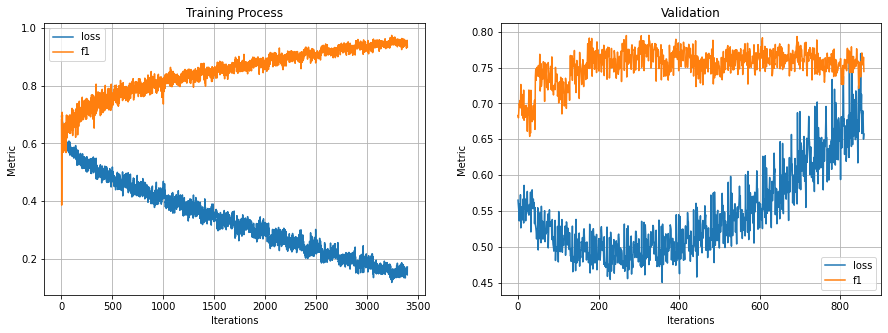

In [27]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

Классно)) Тут явное переобучение, после пятой эпохи лосс начинает расти. Построим еще один график с усредненными по эпохам значениями.

In [28]:
def plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval):

    mean_train_losses = []
    mean_train_f1s = []
    for epoch, losses in enumerate(losses_train):
        mean_train_losses.append(np.mean(losses))
        mean_train_f1s.append(np.mean(f1s_train[epoch]))

    mean_eval_losses = []
    mean_eval_f1s = []
    for epoch, losses in enumerate(losses_eval):
        mean_eval_losses.append(np.mean(losses))
        mean_eval_f1s.append(np.mean(f1s_eval[epoch]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title('BCE Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Metric')
    ax1.plot(mean_train_losses, label='train')
    ax1.plot(mean_eval_losses, label='test')
    ax1.legend()
    ax1.grid()

    ax2.set_title('F1-score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric')
    ax2.plot(mean_train_f1s, label='train')
    ax2.plot(mean_eval_f1s, label='test')
    ax2.legend()
    ax2.grid()

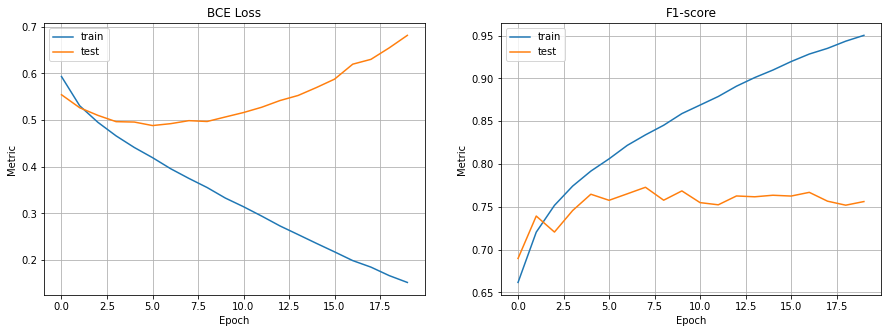

In [29]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Полюбовавшись на переобучение, с чистой совестью приступаем к борьбе с ним.

### Улучшения
#### Dropout

In [30]:
class CNN1(nn.Module):

    def __init__(self, vocab_size, embedding_dim, weights=None):
        super().__init__()
        # эмбеддинг-слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if weights is not None:
            self.embedding.from_pretrained(torch.tensor(weights),
                                           freeze=True)
        # биграммная свертка
        self.bigrams = nn.Conv1d(in_channels=embedding_dim,
                                 out_channels=100, kernel_size=2,
                                 padding='same')
        # триграммная свертка
        self.trigrams = nn.Conv1d(in_channels=embedding_dim,
                                  out_channels=80, kernel_size=3,
                                  padding='same')
        # еще одна биграммная свертка по результатам конкатенации
        self.bigrams_concat = nn.Conv1d(in_channels=180,
                                        out_channels=100,
                                        kernel_size=2,
                                        padding='same')
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        # было batch_size x seq_len

        # batch_size x seq_len x embedding_dim
        embedded = self.embedding(word)
        # batch_size x embedding_dim x seq_len
        embedded = embedded.transpose(1, 2)

        # batch_size x filter_count2 x seq_len*
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.dropout(
            self.relu(self.bigrams_concat(concat)))

        pooling = feature_map_concat.max(2)[0]
        logits = self.hidden(pooling)
        logits = self.out(logits)

        return logits

In [31]:
cnn1_model = CNN1(len(token2id), 100)
optimizer = optim.Adam(cnn1_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

cnn1_model = cnn1_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [32]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(cnn1_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.682480068767772, Train f1: 0.5652458071708679
Train loss: 0.6605046908645069, Train f1: 0.5964860916137695
Train loss: 0.645072249805226, Train f1: 0.6114806532859802
Train loss: 0.6349746909211663, Train f1: 0.6196680665016174
Train loss: 0.6277465417104608, Train f1: 0.6242468357086182

Validating...

Val loss: 0.6001493856310844, Val f1: 0.7046314477920532
Val loss: 0.6014410331845284, Val f1: 0.7030090689659119
Val loss: 0.6018309071660042, Val f1: 0.7054851055145264
Val loss: 0.6023886427283287, Val f1: 0.7039222121238708
Val loss: 0.6020460098981857, Val f1: 0.7041095495223999

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5837686184574576, Train f1: 0.6677794456481934
Train loss: 0.5830500467735178, Train f1: 0.6676827073097229
Train loss: 0.5800644977419984, Train f1: 0.671830415725708
Train loss: 0.5783993351985427, Train f1: 0.6721733212471008
Train loss: 0.5759233380065245, Train f1: 0.6755762696266174

Validating...

Val loss: 0.574798196554184, Val f1: 0.7267909049987793
Val loss: 0.5763556659221649, Val f1: 0.7239519953727722
Val loss: 0.577009859184424, Val f1: 0.7251811623573303
Val loss: 0.5774538628757, Val f1: 0.724865734577179
Val loss: 0.5776199772953987, Val f1: 0.7249942421913147

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5587052492534413, Train f1: 0.695803701877594
Train loss: 0.55641390821513, Train f1: 0.6964948177337646
Train loss: 0.5554824302009508, Train f1: 0.698038637638092
Train loss: 0.552944462527247, Train f1: 0.7010447382926941
Train loss: 0.5514487711822286, Train f1: 0.7034111618995667

Validating...

Val loss: 0.5550357550382614, Val f1: 0.7327108383178711
Val loss: 0.5566996522247791, Val f1: 0.7320671677589417
Val loss: 0.5568644106388092, Val f1: 0.7331563830375671
Val loss: 0.5572449713945389, Val f1: 0.7339657545089722
Val loss: 0.5575789228081703, Val f1: 0.7336360216140747

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5334415611098794, Train f1: 0.7211701273918152
Train loss: 0.5334773221436668, Train f1: 0.7208910584449768
Train loss: 0.5342736197452919, Train f1: 0.7209669947624207
Train loss: 0.5323812457568505, Train f1: 0.7218149304389954
Train loss: 0.5311186194419861, Train f1: 0.7230935096740723

Validating...

Val loss: 0.5384584367275238, Val f1: 0.7450304627418518
Val loss: 0.5403602197766304, Val f1: 0.7444980144500732
Val loss: 0.5405760879317919, Val f1: 0.7457286715507507
Val loss: 0.5408619251102209, Val f1: 0.7465835809707642
Val loss: 0.5416267514228821, Val f1: 0.7455042004585266

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5154347980723661, Train f1: 0.7374253869056702
Train loss: 0.5159305763595244, Train f1: 0.7385144829750061
Train loss: 0.5148655573527018, Train f1: 0.7382718920707703
Train loss: 0.5129514711306375, Train f1: 0.7389723062515259
Train loss: 0.5122136698049657, Train f1: 0.7392752766609192

Validating...

Val loss: 0.5294617563486099, Val f1: 0.753844141960144
Val loss: 0.530747577548027, Val f1: 0.7549596428871155
Val loss: 0.5306026637554169, Val f1: 0.755915641784668
Val loss: 0.5306294094771147, Val f1: 0.7559375762939453
Val loss: 0.5313680171966553, Val f1: 0.7547811269760132

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5006700570092482, Train f1: 0.7502756714820862
Train loss: 0.4997817554018077, Train f1: 0.7503694891929626
Train loss: 0.49966909955529604, Train f1: 0.7499554753303528
Train loss: 0.4983846683274297, Train f1: 0.7496073842048645
Train loss: 0.49729119697037866, Train f1: 0.7504575848579407

Validating...

Val loss: 0.5137928053736687, Val f1: 0.7519435882568359
Val loss: 0.5155485942959785, Val f1: 0.7518676519393921
Val loss: 0.5154317443569502, Val f1: 0.752307653427124
Val loss: 0.5152882356196642, Val f1: 0.7524043321609497
Val loss: 0.5162733376026154, Val f1: 0.7513288259506226

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4834777931956684, Train f1: 0.7578333020210266
Train loss: 0.481806882602327, Train f1: 0.7601063251495361
Train loss: 0.4830952038367589, Train f1: 0.761658787727356
Train loss: 0.4821532738997656, Train f1: 0.7620997428894043
Train loss: 0.4823891892152674, Train f1: 0.7622975707054138

Validating...

Val loss: 0.5071144215762615, Val f1: 0.7596835494041443
Val loss: 0.5093712657690048, Val f1: 0.7614038586616516
Val loss: 0.5091284972925981, Val f1: 0.7626962065696716
Val loss: 0.5088827898725867, Val f1: 0.7628873586654663
Val loss: 0.5098296739161015, Val f1: 0.7620274424552917

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4686204913784476, Train f1: 0.7728447914123535
Train loss: 0.4686741364352843, Train f1: 0.7739264369010925
Train loss: 0.46787485772488163, Train f1: 0.7738612294197083
Train loss: 0.46950053642777834, Train f1: 0.7724935412406921
Train loss: 0.46958530334865345, Train f1: 0.7718624472618103

Validating...

Val loss: 0.498637605458498, Val f1: 0.7582095861434937
Val loss: 0.5008420366793871, Val f1: 0.7580128312110901
Val loss: 0.5003940699001154, Val f1: 0.7603127360343933
Val loss: 0.500142534263432, Val f1: 0.7601061463356018
Val loss: 0.5011764518916607, Val f1: 0.7596583962440491

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4582643456318799, Train f1: 0.7771257758140564
Train loss: 0.45790091244613423, Train f1: 0.7790548205375671
Train loss: 0.4583615301286473, Train f1: 0.7793275713920593
Train loss: 0.45736155593219924, Train f1: 0.7792672514915466
Train loss: 0.4579437494277954, Train f1: 0.7786714434623718

Validating...

Val loss: 0.49776096642017365, Val f1: 0.7672203183174133
Val loss: 0.4999646358191967, Val f1: 0.7694453597068787
Val loss: 0.4993678679068883, Val f1: 0.7704401016235352
Val loss: 0.4991667279973626, Val f1: 0.7711727619171143
Val loss: 0.5003706224262714, Val f1: 0.7709574699401855

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.44755758695742665, Train f1: 0.7891124486923218
Train loss: 0.4465443667243509, Train f1: 0.7886404991149902
Train loss: 0.4465285825963114, Train f1: 0.7884042859077454
Train loss: 0.4461268048514338, Train f1: 0.7883708477020264
Train loss: 0.4469421979259042, Train f1: 0.7875616550445557

Validating...

Val loss: 0.4918814152479172, Val f1: 0.7695833444595337
Val loss: 0.49471164494752884, Val f1: 0.7708181738853455
Val loss: 0.4940522536635399, Val f1: 0.7719290256500244
Val loss: 0.4937705397605896, Val f1: 0.7725884914398193
Val loss: 0.49504196345806123, Val f1: 0.7720470428466797

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4362908610526253, Train f1: 0.7952332496643066
Train loss: 0.4347383923390332, Train f1: 0.7946744561195374
Train loss: 0.4352039180549921, Train f1: 0.7950981259346008
Train loss: 0.43647391239509864, Train f1: 0.7941980957984924
Train loss: 0.4363260335781995, Train f1: 0.7939139604568481

Validating...

Val loss: 0.48411424830555916, Val f1: 0.7632543444633484
Val loss: 0.4868471547961235, Val f1: 0.7637641429901123
Val loss: 0.4861590638756752, Val f1: 0.7643718719482422
Val loss: 0.48570542223751545, Val f1: 0.7644599676132202
Val loss: 0.48705182448029516, Val f1: 0.7644933462142944

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4268493494566749, Train f1: 0.8020951151847839
Train loss: 0.42639106249108033, Train f1: 0.7997388243675232
Train loss: 0.4262550701113308, Train f1: 0.8003886938095093
Train loss: 0.42760688263703794, Train f1: 0.7990939617156982
Train loss: 0.4283817883800058, Train f1: 0.7991395592689514

Validating...

Val loss: 0.4843381978571415, Val f1: 0.7727813720703125
Val loss: 0.4871023837476969, Val f1: 0.7743051052093506
Val loss: 0.4865437274177869, Val f1: 0.7748000025749207
Val loss: 0.48615138977766037, Val f1: 0.7756052017211914
Val loss: 0.48763031214475633, Val f1: 0.7751061320304871

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4238887683433645, Train f1: 0.8013855218887329
Train loss: 0.4193309685763191, Train f1: 0.805425763130188
Train loss: 0.41900263346877753, Train f1: 0.8047274351119995
Train loss: 0.41968728426624746, Train f1: 0.8049907088279724
Train loss: 0.41992387140498444, Train f1: 0.8052628636360168

Validating...

Val loss: 0.4794676825404167, Val f1: 0.7625948190689087
Val loss: 0.4819479640573263, Val f1: 0.7629202604293823
Val loss: 0.4810720793902874, Val f1: 0.7638102173805237
Val loss: 0.48058777675032616, Val f1: 0.7640631198883057
Val loss: 0.4818954117596149, Val f1: 0.76338130235672

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.40764859844656554, Train f1: 0.814085066318512
Train loss: 0.41063069683663983, Train f1: 0.8113824725151062
Train loss: 0.41198913840686574, Train f1: 0.8102681040763855
Train loss: 0.41248749065048557, Train f1: 0.8094130754470825
Train loss: 0.4124929024892695, Train f1: 0.8093579411506653

Validating...

Val loss: 0.48148687556385994, Val f1: 0.7766705751419067
Val loss: 0.4846351034939289, Val f1: 0.7770398855209351
Val loss: 0.48383865381280583, Val f1: 0.7770814895629883
Val loss: 0.48325920943170786, Val f1: 0.7772727012634277
Val loss: 0.4849710166454315, Val f1: 0.7770918607711792

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4016689403968699, Train f1: 0.8147598505020142
Train loss: 0.40294456043664145, Train f1: 0.8150076866149902
Train loss: 0.40429819185359805, Train f1: 0.8143439888954163
Train loss: 0.40514274138738127, Train f1: 0.8130986094474792
Train loss: 0.4048018185531392, Train f1: 0.8135097622871399

Validating...

Val loss: 0.4761389270424843, Val f1: 0.769222617149353
Val loss: 0.4787397850304842, Val f1: 0.7694836258888245
Val loss: 0.47770314166943234, Val f1: 0.7699508666992188
Val loss: 0.4768685195595026, Val f1: 0.7703624963760376
Val loss: 0.4783841878175735, Val f1: 0.7701833844184875

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3918151890530306, Train f1: 0.8223236203193665
Train loss: 0.39371537899269776, Train f1: 0.8202081322669983
Train loss: 0.3940459174268386, Train f1: 0.8213207125663757
Train loss: 0.3965214195058626, Train f1: 0.8189846277236938
Train loss: 0.3973469210021636, Train f1: 0.8181450366973877

Validating...

Val loss: 0.47686032950878143, Val f1: 0.7721527814865112
Val loss: 0.479410232976079, Val f1: 0.771574854850769
Val loss: 0.47846392293771106, Val f1: 0.7711620330810547
Val loss: 0.4777918756008148, Val f1: 0.7709910273551941
Val loss: 0.47933155447244646, Val f1: 0.7705679535865784

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.39165190738790173, Train f1: 0.8217461705207825
Train loss: 0.393074771937202, Train f1: 0.8222472071647644
Train loss: 0.39154434408627303, Train f1: 0.8218855857849121
Train loss: 0.39101431255831437, Train f1: 0.8217512965202332
Train loss: 0.3912155116305632, Train f1: 0.8214653730392456

Validating...

Val loss: 0.47571149095892906, Val f1: 0.7752518057823181
Val loss: 0.478491747751832, Val f1: 0.774095892906189
Val loss: 0.477433526267608, Val f1: 0.7735181450843811
Val loss: 0.47678021155297756, Val f1: 0.7735246419906616
Val loss: 0.4784675635397434, Val f1: 0.7733025550842285

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3804139661438325, Train f1: 0.8275449275970459
Train loss: 0.38138345278361263, Train f1: 0.8273539543151855
Train loss: 0.3816869834474489, Train f1: 0.8278408646583557
Train loss: 0.3840638160267297, Train f1: 0.8267509341239929
Train loss: 0.3851201635949752, Train f1: 0.8253253102302551

Validating...

Val loss: 0.47470318153500557, Val f1: 0.7619839906692505
Val loss: 0.47759336791932583, Val f1: 0.7622872591018677
Val loss: 0.47622532149155933, Val f1: 0.7640822529792786
Val loss: 0.4754392569884658, Val f1: 0.764711856842041
Val loss: 0.47695591673254967, Val f1: 0.7646385431289673

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.37646565191886006, Train f1: 0.8328762054443359
Train loss: 0.3773384773555924, Train f1: 0.832065999507904
Train loss: 0.3773309515387404, Train f1: 0.8318812847137451
Train loss: 0.37826847131637964, Train f1: 0.8311448693275452
Train loss: 0.37961357656647177, Train f1: 0.8297381401062012

Validating...

Val loss: 0.47431303560733795, Val f1: 0.7741010189056396
Val loss: 0.4782389122992754, Val f1: 0.7719607353210449
Val loss: 0.4768372302254041, Val f1: 0.7725302577018738
Val loss: 0.4758632341399789, Val f1: 0.7723197340965271
Val loss: 0.47761853635311124, Val f1: 0.7717310786247253

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.36935897960382347, Train f1: 0.8354817628860474
Train loss: 0.3701762824374087, Train f1: 0.8346983790397644
Train loss: 0.3720246971237893, Train f1: 0.8333471417427063
Train loss: 0.37372550784664993, Train f1: 0.8327282667160034
Train loss: 0.3740171416717417, Train f1: 0.8324195146560669

Validating...

Val loss: 0.47442566975951195, Val f1: 0.7712193131446838
Val loss: 0.47808307595551014, Val f1: 0.771314263343811
Val loss: 0.4769771546125412, Val f1: 0.7711966633796692
Val loss: 0.4758280757814646, Val f1: 0.7707524299621582
Val loss: 0.4774617187678814, Val f1: 0.7702218890190125


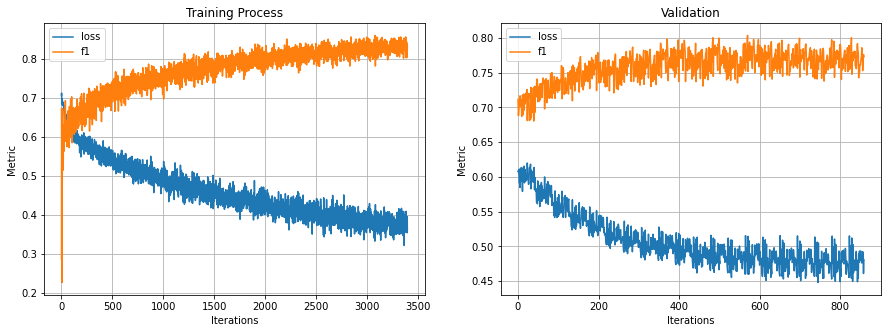

In [33]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

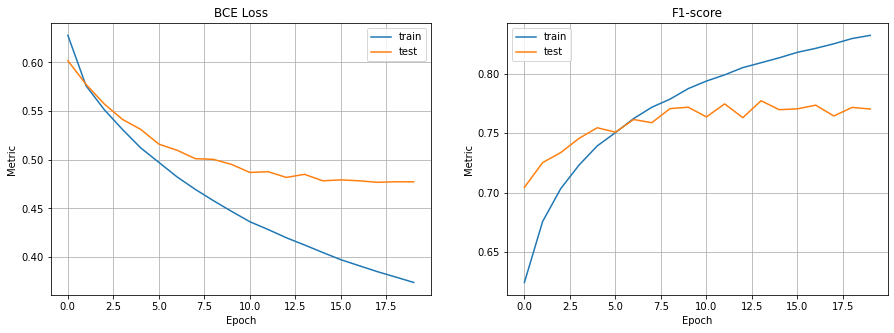

In [34]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Помогло, но есть ощущение, что мы делаем что-то лишнее: после 10-15 эпох f1 уже не растет.

In [35]:
print(
    'CNN без FastText-эмбеддингов до улучшений: loss = {}, f1 = {}'.format(
        initial_cnn_loss, initial_cnn_f1))

# здесь и далее переменные метрик начинаются с initial,
# потому что сначала я забыла поменять, а теперь мне лень))
initial_cnn1_loss = np.mean(losses_eval[-1])
initial_cnn1_f1 = np.mean(f1s_eval[-1])
print(
    'CNN без FastText-эмбеддингов с dropout\'ом: loss = {}, f1 = {}'.format(
        initial_cnn1_loss, initial_cnn1_f1))

CNN без FastText-эмбеддингов до улучшений: loss = 0.6815855724867, f1 = 0.7562121152877808
CNN без FastText-эмбеддингов с dropout'ом: loss = 0.47734160548032717, f1 = 0.770354151725769


#### Нормализация
С переобучением мы вроде как справились, но я добавляла эпох и видела, что снова появляется такая тенденция, поэтому решила добавить еще и нормализацию.

Я не с ИАДа, поэтому эту часть честно нагуглила. Источники: [Deep Learning #3: More on CNNs & Handling Overfitting](https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d), [Batch Normalization and Dropout in Neural Networks with Pytorch](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd).

In [36]:
class CNN2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, weights=None):
        super().__init__()
        # эмбеддинг-слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if weights is not None:
            self.embedding.from_pretrained(torch.tensor(weights),
                                           freeze=True)
        # биграммная свертка
        self.bigrams = nn.Conv1d(in_channels=embedding_dim,
                                 out_channels=100, kernel_size=2,
                                 padding='same')
        # триграммная свертка
        self.trigrams = nn.Conv1d(in_channels=embedding_dim,
                                  out_channels=80, kernel_size=3,
                                  padding='same')
        # еще одна биграммная свертка по результатам конкатенации
        self.bigrams_concat = nn.Conv1d(in_channels=180,
                                        out_channels=100,
                                        kernel_size=2,
                                        padding='same')
        self.batch_norm2 = nn.BatchNorm1d(100)
        self.batch_norm3 = nn.BatchNorm1d(80)
        self.batch_norm_conc = nn.BatchNorm1d(100)

        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        # было batch_size x seq_len

        # batch_size x seq_len x embedding_dim
        embedded = self.embedding(word)
        # batch_size x embedding_dim x seq_len
        embedded = embedded.transpose(1, 2)

        # batch_size x filter_count2 x seq_len*
        feature_map_bigrams = self.batch_norm2(
            self.dropout(self.relu(self.bigrams(embedded))))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.batch_norm3(
            self.dropout(self.relu(self.trigrams(embedded))))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.batch_norm_conc(
            self.dropout(self.relu(self.bigrams_concat(concat))))

        pooling = feature_map_concat.max(2)[0]
        logits = self.hidden(pooling)
        logits = self.out(logits)

        return logits

In [37]:
cnn2_model = CNN2(len(token2id), 100)
optimizer = optim.Adam(cnn2_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

cnn2_model = cnn2_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [38]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(cnn2_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7111220763010138, Train f1: 0.5813007354736328
Train loss: 0.6818657298298443, Train f1: 0.5970120429992676
Train loss: 0.6653557302905064, Train f1: 0.6063671708106995
Train loss: 0.6548692281631863, Train f1: 0.6114583611488342
Train loss: 0.6466287830296684, Train f1: 0.6180866956710815

Validating...

Val loss: 0.6210476383566856, Val f1: 0.7059957385063171
Val loss: 0.6212870441377163, Val f1: 0.7029871940612793
Val loss: 0.621550569931666, Val f1: 0.7048147320747375
Val loss: 0.6220316626131535, Val f1: 0.7043518424034119
Val loss: 0.6222478449344635, Val f1: 0.7052004337310791

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6039918924079222, Train f1: 0.6470760107040405
Train loss: 0.6011242805158391, Train f1: 0.652606725692749
Train loss: 0.6001597964296154, Train f1: 0.6537956595420837
Train loss: 0.5967267273980028, Train f1: 0.6582997441291809
Train loss: 0.5939149800468894, Train f1: 0.6603485941886902

Validating...

Val loss: 0.6024043560028076, Val f1: 0.7183895111083984
Val loss: 0.6035060957074165, Val f1: 0.7156734466552734
Val loss: 0.603845439851284, Val f1: 0.7185247540473938
Val loss: 0.6042757481336594, Val f1: 0.7187384366989136
Val loss: 0.6047330737113953, Val f1: 0.7190103530883789

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5768321086378658, Train f1: 0.6801232695579529
Train loss: 0.5758119628709906, Train f1: 0.684085488319397
Train loss: 0.5736245174033969, Train f1: 0.6853244304656982
Train loss: 0.5716874871183845, Train f1: 0.6868335008621216
Train loss: 0.5700495579663445, Train f1: 0.6882537603378296

Validating...

Val loss: 0.5806901082396507, Val f1: 0.7300136089324951
Val loss: 0.5816499851644039, Val f1: 0.7288404703140259
Val loss: 0.5816506122549375, Val f1: 0.731822669506073
Val loss: 0.5822020210325718, Val f1: 0.7308409214019775
Val loss: 0.5828237071633339, Val f1: 0.7318164706230164

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5557906312101027, Train f1: 0.7015596032142639
Train loss: 0.5543267209740246, Train f1: 0.7027344703674316
Train loss: 0.5535618879047095, Train f1: 0.7028926014900208
Train loss: 0.5512129160411218, Train f1: 0.704836905002594
Train loss: 0.5492773932569167, Train f1: 0.7066138386726379

Validating...

Val loss: 0.5586933344602585, Val f1: 0.7422012090682983
Val loss: 0.5599482618272305, Val f1: 0.7408186197280884
Val loss: 0.5601020356019338, Val f1: 0.7424556612968445
Val loss: 0.56045494787395, Val f1: 0.7409456968307495
Val loss: 0.5613339558243752, Val f1: 0.7418495416641235

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5321949790505802, Train f1: 0.7221797704696655
Train loss: 0.5359360566910576, Train f1: 0.7190634608268738
Train loss: 0.5334214398673937, Train f1: 0.7213349342346191
Train loss: 0.5312143871012855, Train f1: 0.7231870293617249
Train loss: 0.5301351417513455, Train f1: 0.7250041365623474

Validating...

Val loss: 0.5534271821379662, Val f1: 0.7466193437576294
Val loss: 0.5554270073771477, Val f1: 0.7455891370773315
Val loss: 0.5557002052664757, Val f1: 0.7468116879463196
Val loss: 0.5558818187564611, Val f1: 0.746000349521637
Val loss: 0.5570178851485252, Val f1: 0.7472783327102661

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.518137077198309, Train f1: 0.7372915744781494
Train loss: 0.516492127933923, Train f1: 0.735465407371521
Train loss: 0.5162908285856247, Train f1: 0.7379743456840515
Train loss: 0.5156386428896118, Train f1: 0.737762451171875
Train loss: 0.5149187796256122, Train f1: 0.7389684915542603

Validating...

Val loss: 0.5365134328603745, Val f1: 0.757587194442749
Val loss: 0.5387483052909374, Val f1: 0.754074215888977
Val loss: 0.539447712401549, Val f1: 0.755262553691864
Val loss: 0.5396185796707869, Val f1: 0.7540826797485352
Val loss: 0.5408354341983795, Val f1: 0.7546049356460571

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.502458137624404, Train f1: 0.7443963885307312
Train loss: 0.5001870183383718, Train f1: 0.7476428151130676
Train loss: 0.5007187128067017, Train f1: 0.7487078905105591
Train loss: 0.4993165676646373, Train f1: 0.7505929470062256
Train loss: 0.5001981026986067, Train f1: 0.7499822974205017

Validating...

Val loss: 0.5306836143136024, Val f1: 0.7611722946166992
Val loss: 0.5337976701557636, Val f1: 0.7584105730056763
Val loss: 0.5343345751365026, Val f1: 0.7594693303108215
Val loss: 0.53421925380826, Val f1: 0.7583266496658325
Val loss: 0.53529392182827, Val f1: 0.7587068676948547

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49021317327723785, Train f1: 0.7588732242584229
Train loss: 0.48977116845986424, Train f1: 0.7569347620010376
Train loss: 0.4886452152448542, Train f1: 0.7572277188301086
Train loss: 0.4878202985753031, Train f1: 0.7580432891845703
Train loss: 0.48671276621958787, Train f1: 0.7596487402915955

Validating...

Val loss: 0.5187627971172333, Val f1: 0.7669334411621094
Val loss: 0.5217417143285275, Val f1: 0.7627255320549011
Val loss: 0.5223833719889323, Val f1: 0.7649776339530945
Val loss: 0.5219819974154234, Val f1: 0.7639308571815491
Val loss: 0.5232006192207337, Val f1: 0.7639873027801514

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4750049193115795, Train f1: 0.7669240236282349
Train loss: 0.4741649715339436, Train f1: 0.7685017585754395
Train loss: 0.4738416163360371, Train f1: 0.7696609497070312
Train loss: 0.4741431084625861, Train f1: 0.7693616151809692
Train loss: 0.4748635255238589, Train f1: 0.76849365234375

Validating...

Val loss: 0.5143048577010632, Val f1: 0.769100546836853
Val loss: 0.5177742708474398, Val f1: 0.7655259370803833
Val loss: 0.5181680805981159, Val f1: 0.7675228714942932
Val loss: 0.517641969025135, Val f1: 0.767326295375824
Val loss: 0.5187726140022277, Val f1: 0.7674658894538879

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46080971991314607, Train f1: 0.7816914319992065
Train loss: 0.4617276266217232, Train f1: 0.7777504920959473
Train loss: 0.4634133776028951, Train f1: 0.7760197520256042
Train loss: 0.4638830819988952, Train f1: 0.7752184271812439
Train loss: 0.4641899519106921, Train f1: 0.7756285071372986

Validating...

Val loss: 0.5074486806988716, Val f1: 0.7727655172348022
Val loss: 0.5107589066028595, Val f1: 0.769380509853363
Val loss: 0.5112267956137657, Val f1: 0.7706908583641052
Val loss: 0.510489784181118, Val f1: 0.7710040807723999
Val loss: 0.5117840275168419, Val f1: 0.7705909013748169

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4534621308831608, Train f1: 0.7836786508560181
Train loss: 0.4532942460740314, Train f1: 0.7830466628074646
Train loss: 0.4533894999938853, Train f1: 0.7837944030761719
Train loss: 0.4512021026628859, Train f1: 0.7848573923110962
Train loss: 0.45252325552351336, Train f1: 0.7840001583099365

Validating...

Val loss: 0.49907781183719635, Val f1: 0.7743855714797974
Val loss: 0.5023473091423512, Val f1: 0.7710535526275635
Val loss: 0.5029301096995672, Val f1: 0.7720447182655334
Val loss: 0.5021429229527712, Val f1: 0.7720149755477905
Val loss: 0.5035077296197414, Val f1: 0.771868109703064

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.44304133338086743, Train f1: 0.7907779812812805
Train loss: 0.4446101508596364, Train f1: 0.7877878546714783
Train loss: 0.445576333824326, Train f1: 0.7876838445663452
Train loss: 0.44513487443327904, Train f1: 0.7877446413040161
Train loss: 0.44371098700691675, Train f1: 0.7891626954078674

Validating...

Val loss: 0.49493518844246864, Val f1: 0.7736638784408569
Val loss: 0.4978384766727686, Val f1: 0.7715646624565125
Val loss: 0.49830420315265656, Val f1: 0.7725834846496582
Val loss: 0.4973077969625592, Val f1: 0.772594690322876
Val loss: 0.4987481690943241, Val f1: 0.7721173167228699

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4352360709625132, Train f1: 0.7946993112564087
Train loss: 0.4341147896998069, Train f1: 0.7980066537857056
Train loss: 0.43176886439323425, Train f1: 0.7987191677093506
Train loss: 0.43297562792020683, Train f1: 0.7973713874816895
Train loss: 0.43350223898887635, Train f1: 0.7968887090682983

Validating...

Val loss: 0.49063365533947945, Val f1: 0.7756311893463135
Val loss: 0.49415358155965805, Val f1: 0.7738851308822632
Val loss: 0.4945445793370406, Val f1: 0.7752067446708679
Val loss: 0.49363425467163324, Val f1: 0.7756914496421814
Val loss: 0.4952656112611294, Val f1: 0.7749077081680298

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4228169392136967, Train f1: 0.8041144013404846
Train loss: 0.42460889369249344, Train f1: 0.8027119636535645
Train loss: 0.42496030324814366, Train f1: 0.8027950525283813
Train loss: 0.42422553546288433, Train f1: 0.8031231164932251
Train loss: 0.4250444843488581, Train f1: 0.8024063110351562

Validating...

Val loss: 0.4896211251616478, Val f1: 0.7755678296089172
Val loss: 0.49283561296761036, Val f1: 0.775601863861084
Val loss: 0.493248683710893, Val f1: 0.7764291763305664
Val loss: 0.4920769892632961, Val f1: 0.7767665386199951
Val loss: 0.493773053586483, Val f1: 0.776290237903595

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4166732430458069, Train f1: 0.8073449730873108
Train loss: 0.4132376120370977, Train f1: 0.8091177940368652
Train loss: 0.41460293239238216, Train f1: 0.807984471321106
Train loss: 0.4151708087062134, Train f1: 0.8079813122749329
Train loss: 0.41717522810487184, Train f1: 0.8061617016792297

Validating...

Val loss: 0.48843467980623245, Val f1: 0.7770166397094727
Val loss: 0.49153351224958897, Val f1: 0.7752955555915833
Val loss: 0.4917803518474102, Val f1: 0.7761716842651367
Val loss: 0.49077627528458834, Val f1: 0.7765393257141113
Val loss: 0.4926374316215515, Val f1: 0.7758227586746216

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.40723124058807597, Train f1: 0.8110268712043762
Train loss: 0.4070086715852513, Train f1: 0.8129940032958984
Train loss: 0.4085714478118747, Train f1: 0.8124406337738037
Train loss: 0.40809059011585574, Train f1: 0.812359631061554
Train loss: 0.4096837119144552, Train f1: 0.8113669753074646

Validating...

Val loss: 0.4871811121702194, Val f1: 0.775631308555603
Val loss: 0.4898145217448473, Val f1: 0.7751201391220093
Val loss: 0.49008355910579365, Val f1: 0.7770606875419617
Val loss: 0.4892266867682338, Val f1: 0.7769922614097595
Val loss: 0.4910179600119591, Val f1: 0.7762948870658875

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3990582920172635, Train f1: 0.8175181746482849
Train loss: 0.4001418878050411, Train f1: 0.8158822059631348
Train loss: 0.4026210018817116, Train f1: 0.8154006600379944
Train loss: 0.4026662808130769, Train f1: 0.8153923153877258
Train loss: 0.4027120423667571, Train f1: 0.8155941367149353

Validating...

Val loss: 0.4820685423910618, Val f1: 0.7759394645690918
Val loss: 0.4849137533456087, Val f1: 0.7768709659576416
Val loss: 0.48540426169832546, Val f1: 0.7781792283058167
Val loss: 0.48442912567406893, Val f1: 0.7779324650764465
Val loss: 0.4864197425544262, Val f1: 0.7771618962287903

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.39630236520486717, Train f1: 0.8199772238731384
Train loss: 0.3953707121750888, Train f1: 0.8211630582809448
Train loss: 0.3948138289007486, Train f1: 0.8206936717033386
Train loss: 0.39526558053844113, Train f1: 0.8202433586120605
Train loss: 0.3963071558405371, Train f1: 0.819187581539154

Validating...

Val loss: 0.4843072481453419, Val f1: 0.775628924369812
Val loss: 0.48699465207755566, Val f1: 0.7767626047134399
Val loss: 0.4876142976184686, Val f1: 0.7780373096466064
Val loss: 0.48638321179896593, Val f1: 0.778078556060791
Val loss: 0.4883259065449238, Val f1: 0.7778896689414978

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3823709838530597, Train f1: 0.8265977501869202
Train loss: 0.38550424049882326, Train f1: 0.8257718682289124
Train loss: 0.3878771651024912, Train f1: 0.8240708708763123
Train loss: 0.38809705635204034, Train f1: 0.8241802453994751
Train loss: 0.3895437473759932, Train f1: 0.822570264339447

Validating...

Val loss: 0.48627983778715134, Val f1: 0.7771322131156921
Val loss: 0.4888551365584135, Val f1: 0.7773340940475464
Val loss: 0.4892342189947764, Val f1: 0.7793181538581848
Val loss: 0.48803637363016605, Val f1: 0.7788249850273132
Val loss: 0.490051631629467, Val f1: 0.7787145376205444

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3779078169780619, Train f1: 0.8298225998878479
Train loss: 0.38182088864200253, Train f1: 0.8279069662094116
Train loss: 0.3806769809886521, Train f1: 0.8292717933654785
Train loss: 0.3828135218252154, Train f1: 0.8272497057914734
Train loss: 0.3836096227169037, Train f1: 0.8263370394706726

Validating...

Val loss: 0.4805714376270771, Val f1: 0.7769090533256531
Val loss: 0.48326090909540653, Val f1: 0.7776823043823242
Val loss: 0.4835745692253113, Val f1: 0.778571367263794
Val loss: 0.4822831470519304, Val f1: 0.7784463763237
Val loss: 0.4844094730913639, Val f1: 0.7778950929641724


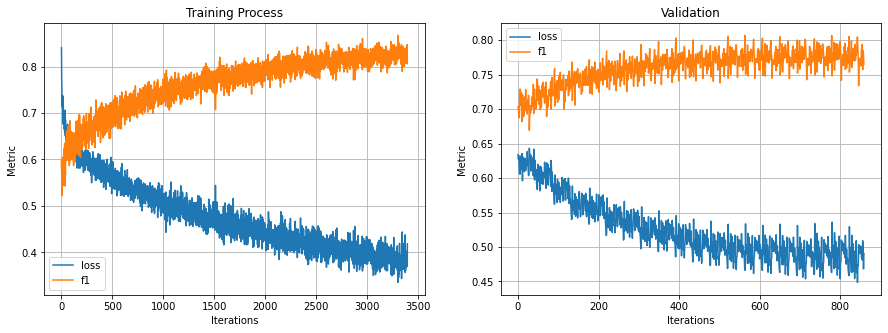

In [39]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

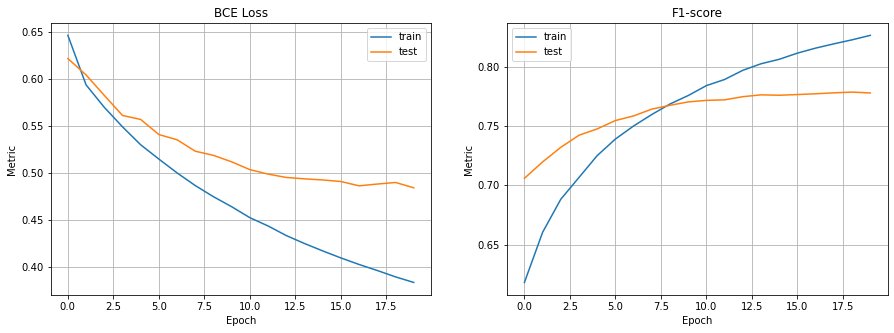

In [40]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Радикальных изменений не произошло, но есть ощущение, что нужно взять чуть меньше эпох: после 15-ой f1 на тесте уже практически не меняется, а вот лосс показывает какие-то подозрительные тенденции к переобучению.

In [41]:
print(
    'CNN без FastText-эмбеддингов с dropout\'ом: loss = {}, f1 = {}'.format(
        initial_cnn1_loss, initial_cnn1_f1))

initial_cnn2_loss = np.mean(losses_eval[-1])
initial_cnn2_f1 = np.mean(f1s_eval[-1])
print(
    'CNN без FastText с dropout и нормализацией: loss = {}, f1 = {}'.format(
        initial_cnn2_loss, initial_cnn2_f1))

CNN без FastText-эмбеддингов с dropout'ом: loss = 0.47734160548032717, f1 = 0.770354151725769
CNN без FastText с dropout и нормализацией: loss = 0.48438102769297225, f1 = 0.7777900099754333


#### Размер эмбеддингов
А что, если поменять размер эмбеддингов? Сделаем embedding_size в два раза меньше -- у нас не очень много данных. Остальные параметры оставляем такими, как у предыдущей модели.

In [42]:
cnn2_model = CNN2(len(token2id), 50)
optimizer = optim.Adam(cnn2_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

cnn2_model = cnn2_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [43]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(cnn2_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.8594917602398816, Train f1: 0.5811858773231506
Train loss: 0.7712278848185259, Train f1: 0.5871900320053101
Train loss: 0.7330342595483742, Train f1: 0.594006359577179
Train loss: 0.7098797270480324, Train f1: 0.6000629663467407
Train loss: 0.6943277720142813, Train f1: 0.604625940322876

Validating...

Val loss: 0.6434697434306145, Val f1: 0.6921558380126953
Val loss: 0.6439476162195206, Val f1: 0.6928104162216187
Val loss: 0.644082692762216, Val f1: 0.6935582160949707
Val loss: 0.6443756725639105, Val f1: 0.6939165592193604
Val loss: 0.6442258909344674, Val f1: 0.693914532661438

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6261969436617458, Train f1: 0.62776780128479
Train loss: 0.6239716577179292, Train f1: 0.6207435131072998
Train loss: 0.6215224791975582, Train f1: 0.6243504285812378
Train loss: 0.6188239073928665, Train f1: 0.6295908093452454
Train loss: 0.6162764594835394, Train f1: 0.632101833820343

Validating...

Val loss: 0.6315168142318726, Val f1: 0.7023804187774658
Val loss: 0.6323681175708771, Val f1: 0.7011922001838684
Val loss: 0.6324069648981094, Val f1: 0.7012452483177185
Val loss: 0.6326646916568279, Val f1: 0.7008343935012817
Val loss: 0.632681442797184, Val f1: 0.7011896967887878

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6023194965194253, Train f1: 0.6465373635292053
Train loss: 0.6024670495706446, Train f1: 0.645671010017395
Train loss: 0.6009520894172145, Train f1: 0.6494715809822083
Train loss: 0.5991322853985954, Train f1: 0.651750922203064
Train loss: 0.5986281307304606, Train f1: 0.6525613069534302

Validating...

Val loss: 0.613438293337822, Val f1: 0.7086300253868103
Val loss: 0.614459153264761, Val f1: 0.7099018096923828
Val loss: 0.6146964902679125, Val f1: 0.709313154220581
Val loss: 0.6149242576211691, Val f1: 0.7089459896087646
Val loss: 0.6151270180940628, Val f1: 0.7090347409248352

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.589179079322254, Train f1: 0.66350257396698
Train loss: 0.5887628513223985, Train f1: 0.6662843227386475
Train loss: 0.5858177793960945, Train f1: 0.6676941514015198
Train loss: 0.5843013288343654, Train f1: 0.6690713167190552
Train loss: 0.5832351414596333, Train f1: 0.6700118780136108

Validating...

Val loss: 0.6024507284164429, Val f1: 0.7183182239532471
Val loss: 0.6035687997937202, Val f1: 0.7186551094055176
Val loss: 0.6038480227192243, Val f1: 0.7186720967292786
Val loss: 0.6039362195879221, Val f1: 0.718585193157196
Val loss: 0.6043030098080635, Val f1: 0.7183884978294373

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5717464597786174, Train f1: 0.6842564940452576
Train loss: 0.5709461859043907, Train f1: 0.6834574341773987
Train loss: 0.5709178260728425, Train f1: 0.6827710270881653
Train loss: 0.5690038738881841, Train f1: 0.6856346726417542
Train loss: 0.56892691079308, Train f1: 0.6855743527412415

Validating...

Val loss: 0.5936027392745018, Val f1: 0.724531352519989
Val loss: 0.5949153453111649, Val f1: 0.7243175506591797
Val loss: 0.5949806943535805, Val f1: 0.7249041199684143
Val loss: 0.5949292778968811, Val f1: 0.7248455286026001
Val loss: 0.5954024627804756, Val f1: 0.7249702215194702

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5592640515635995, Train f1: 0.6975612640380859
Train loss: 0.5593090074903825, Train f1: 0.6950438618659973
Train loss: 0.558613613540051, Train f1: 0.6965960264205933
Train loss: 0.5572359189391136, Train f1: 0.6986116170883179
Train loss: 0.5556995318216436, Train f1: 0.7005584836006165

Validating...

Val loss: 0.5771063044667244, Val f1: 0.7382371425628662
Val loss: 0.578225877135992, Val f1: 0.7358801364898682
Val loss: 0.57820542405049, Val f1: 0.7367972731590271
Val loss: 0.5779668875038624, Val f1: 0.7364295721054077
Val loss: 0.5785994842648506, Val f1: 0.7364420890808105

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5455808394095477, Train f1: 0.7126410007476807
Train loss: 0.544522200437153, Train f1: 0.7103780508041382
Train loss: 0.5426695767570945, Train f1: 0.7126564979553223
Train loss: 0.5414703549707637, Train f1: 0.713116466999054
Train loss: 0.5409292326254003, Train f1: 0.7139854431152344

Validating...

Val loss: 0.5661744698882103, Val f1: 0.7424064874649048
Val loss: 0.5667624026536942, Val f1: 0.7415920495986938
Val loss: 0.5669217929244041, Val f1: 0.7433090209960938
Val loss: 0.5665886141359806, Val f1: 0.7428332567214966
Val loss: 0.5674411430954933, Val f1: 0.7428401112556458

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5307170135133407, Train f1: 0.7253338694572449
Train loss: 0.5294388173257604, Train f1: 0.7244292497634888
Train loss: 0.5273498089290133, Train f1: 0.7274982333183289
Train loss: 0.5275350057465189, Train f1: 0.7276697158813477
Train loss: 0.5275861286065158, Train f1: 0.7277767062187195

Validating...

Val loss: 0.5564821884036064, Val f1: 0.7514559030532837
Val loss: 0.5571523271501064, Val f1: 0.7486163377761841
Val loss: 0.5574232190847397, Val f1: 0.7499299049377441
Val loss: 0.5570812318474054, Val f1: 0.748568058013916
Val loss: 0.5579689919948578, Val f1: 0.7486047744750977

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5220395440564436, Train f1: 0.7310456037521362
Train loss: 0.5207319439334028, Train f1: 0.7320266962051392
Train loss: 0.5186408398782506, Train f1: 0.7338969111442566
Train loss: 0.5179507572423009, Train f1: 0.7352299690246582
Train loss: 0.517384371862692, Train f1: 0.7366018295288086

Validating...

Val loss: 0.5500327944755554, Val f1: 0.7535750269889832
Val loss: 0.5507812984287739, Val f1: 0.7509855031967163
Val loss: 0.5509557525316874, Val f1: 0.7533401846885681
Val loss: 0.5504927523434162, Val f1: 0.7526528239250183
Val loss: 0.5513648614287376, Val f1: 0.7527434825897217

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5069687962532043, Train f1: 0.744655430316925
Train loss: 0.505645665614044, Train f1: 0.7438708543777466
Train loss: 0.5056814720817641, Train f1: 0.7433612942695618
Train loss: 0.5052682284046622, Train f1: 0.7440986633300781
Train loss: 0.5051816563395893, Train f1: 0.7439336776733398

Validating...

Val loss: 0.5393860191106796, Val f1: 0.7570146918296814
Val loss: 0.5403987094759941, Val f1: 0.7548067569732666
Val loss: 0.5404134765267372, Val f1: 0.7567224502563477
Val loss: 0.5397479701787233, Val f1: 0.7570793628692627
Val loss: 0.5407701015472413, Val f1: 0.7576175928115845

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49454500570016746, Train f1: 0.7527422308921814
Train loss: 0.4941977792802979, Train f1: 0.7528290152549744
Train loss: 0.49427397344626633, Train f1: 0.7531858682632446
Train loss: 0.49453112263889876, Train f1: 0.7529778480529785
Train loss: 0.4947577360798331, Train f1: 0.753061830997467

Validating...

Val loss: 0.5320504829287529, Val f1: 0.7594884634017944
Val loss: 0.5331944264471531, Val f1: 0.7585217952728271
Val loss: 0.5331867237885793, Val f1: 0.760969340801239
Val loss: 0.5324249919503927, Val f1: 0.7608474493026733
Val loss: 0.5334709256887435, Val f1: 0.7606746554374695

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4846178363351261, Train f1: 0.7620996832847595
Train loss: 0.4824141347232987, Train f1: 0.7633336782455444
Train loss: 0.48280155366542293, Train f1: 0.762130081653595
Train loss: 0.48411651744562034, Train f1: 0.7610945105552673
Train loss: 0.485277358398718, Train f1: 0.7605018019676208

Validating...

Val loss: 0.5270590111613274, Val f1: 0.7627576589584351
Val loss: 0.5281315669417381, Val f1: 0.7618237733840942
Val loss: 0.5280644049247106, Val f1: 0.7642280459403992
Val loss: 0.527261545881629, Val f1: 0.7636328339576721
Val loss: 0.528330497443676, Val f1: 0.7634523510932922

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.47421035170555115, Train f1: 0.764529287815094
Train loss: 0.4785922099562252, Train f1: 0.762531578540802
Train loss: 0.47845589267272576, Train f1: 0.7648307681083679
Train loss: 0.4781598025823341, Train f1: 0.7657217979431152
Train loss: 0.47774520463803233, Train f1: 0.7661668062210083

Validating...

Val loss: 0.5186048373579979, Val f1: 0.7654546499252319
Val loss: 0.5199256911873817, Val f1: 0.7631695866584778
Val loss: 0.5197578792770704, Val f1: 0.7661959528923035
Val loss: 0.5187047272920609, Val f1: 0.766176164150238
Val loss: 0.5199119731783867, Val f1: 0.76594477891922

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46425990935634165, Train f1: 0.7761483788490295
Train loss: 0.4686330026563476, Train f1: 0.7715497016906738
Train loss: 0.4704146852680281, Train f1: 0.7710337042808533
Train loss: 0.4695573416264618, Train f1: 0.7716641426086426
Train loss: 0.46948125099434573, Train f1: 0.7717398405075073

Validating...

Val loss: 0.5159064680337906, Val f1: 0.767848014831543
Val loss: 0.5169119611382484, Val f1: 0.7654789686203003
Val loss: 0.5166866555809975, Val f1: 0.7681975960731506
Val loss: 0.5154513260349631, Val f1: 0.7673631906509399
Val loss: 0.5165860883891582, Val f1: 0.7674168348312378

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4614620874909794, Train f1: 0.779414176940918
Train loss: 0.46246812404955134, Train f1: 0.7760127186775208
Train loss: 0.4627234868559183, Train f1: 0.7764309048652649
Train loss: 0.4613596981062609, Train f1: 0.7771586179733276
Train loss: 0.46155450764824363, Train f1: 0.7769906520843506

Validating...

Val loss: 0.5142387039959431, Val f1: 0.7685099840164185
Val loss: 0.5153321791440248, Val f1: 0.7673414349555969
Val loss: 0.51494117329518, Val f1: 0.7702760100364685
Val loss: 0.5137360729277134, Val f1: 0.7695189714431763
Val loss: 0.5149153739213943, Val f1: 0.7696022987365723

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.45412955652264986, Train f1: 0.780982255935669
Train loss: 0.453889614518951, Train f1: 0.7819744348526001
Train loss: 0.45320549022917656, Train f1: 0.782902717590332
Train loss: 0.45476289422196503, Train f1: 0.7824413180351257
Train loss: 0.45499329426709345, Train f1: 0.7821245789527893

Validating...

Val loss: 0.5121077969670296, Val f1: 0.7683233022689819
Val loss: 0.513302044942975, Val f1: 0.7687606811523438
Val loss: 0.5131278919676939, Val f1: 0.771608829498291
Val loss: 0.5118412412703037, Val f1: 0.7714921832084656
Val loss: 0.5130904152989387, Val f1: 0.7717944383621216

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4474530991385965, Train f1: 0.7873769402503967
Train loss: 0.4455499504418934, Train f1: 0.7883265018463135
Train loss: 0.44645975822327183, Train f1: 0.7878168821334839
Train loss: 0.4469447464627378, Train f1: 0.7873731255531311
Train loss: 0.44678003104294045, Train f1: 0.7872543334960938

Validating...

Val loss: 0.5045531056821346, Val f1: 0.7715727090835571
Val loss: 0.5054159574210644, Val f1: 0.7713900208473206
Val loss: 0.5053330572942892, Val f1: 0.7735066413879395
Val loss: 0.5037643192335963, Val f1: 0.7730647325515747
Val loss: 0.5049759417772293, Val f1: 0.7730602025985718

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.43944021708825054, Train f1: 0.7921210527420044
Train loss: 0.44140399904812083, Train f1: 0.7907852530479431
Train loss: 0.4419071393854478, Train f1: 0.7907407879829407
Train loss: 0.44064487363485727, Train f1: 0.7914147973060608
Train loss: 0.4408775483860689, Train f1: 0.7913931608200073

Validating...

Val loss: 0.5001996271312237, Val f1: 0.7735422253608704
Val loss: 0.5010833162814379, Val f1: 0.7710360288619995
Val loss: 0.5008920480807623, Val f1: 0.7735710740089417
Val loss: 0.4991993550211191, Val f1: 0.7736102938652039
Val loss: 0.5004552438855171, Val f1: 0.7739454507827759

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.43426863673855276, Train f1: 0.796097457408905
Train loss: 0.43439747831400705, Train f1: 0.7960917353630066
Train loss: 0.43376200573117124, Train f1: 0.7962384819984436
Train loss: 0.4339432350414641, Train f1: 0.7956713438034058
Train loss: 0.4340971068424337, Train f1: 0.795661449432373

Validating...

Val loss: 0.5030084513127804, Val f1: 0.7753887176513672
Val loss: 0.5041762553155422, Val f1: 0.7739489674568176
Val loss: 0.5038617712755998, Val f1: 0.776404857635498
Val loss: 0.5021271975710988, Val f1: 0.7761465311050415
Val loss: 0.5034478083252907, Val f1: 0.7763190269470215

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4257051541524775, Train f1: 0.8019378781318665
Train loss: 0.4262869691147524, Train f1: 0.801749050617218
Train loss: 0.42786602266863283, Train f1: 0.8011019825935364
Train loss: 0.4282524270169875, Train f1: 0.7999857664108276
Train loss: 0.4288445879431332, Train f1: 0.7986834645271301

Validating...

Val loss: 0.499418031424284, Val f1: 0.7748874425888062
Val loss: 0.5002509597688913, Val f1: 0.774426281452179
Val loss: 0.499917346984148, Val f1: 0.7753379940986633
Val loss: 0.49800490587949753, Val f1: 0.7754186391830444
Val loss: 0.4992395415902138, Val f1: 0.7757407426834106


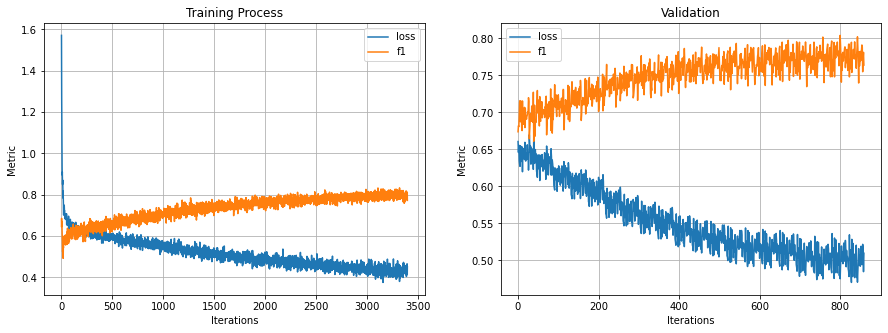

In [44]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

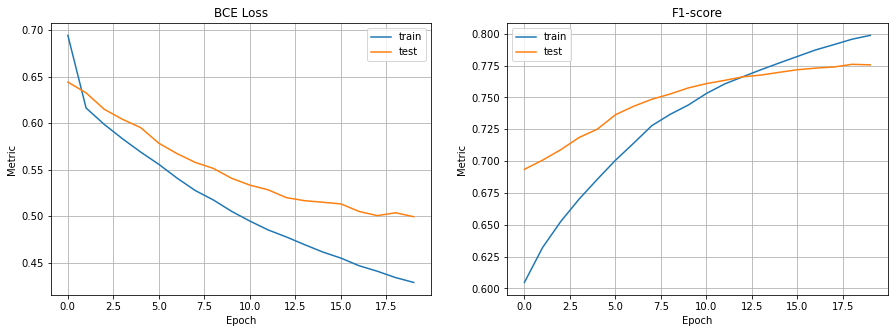

In [45]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

In [46]:
print(
    'CNN без FastText с dropout и нормализацией: loss = {}, f1 = {}'.format(
        initial_cnn2_loss, initial_cnn2_f1))

initial_cnn3_loss = np.mean(losses_eval[-1])
initial_cnn3_f1 = np.mean(f1s_eval[-1])
print(
    'CNN с dropout\'ом и размером эмбеддинга 50: loss = {}, f1 = {}'.format(
        initial_cnn3_loss, initial_cnn3_f1))

CNN без FastText с dropout и нормализацией: loss = 0.48438102769297225, f1 = 0.7777900099754333
CNN с dropout'ом и размером эмбеддинга 50: loss = 0.49946843607481134, f1 = 0.7755183577537537


Нет, стало хуже: лосс чуть выше, f1 чуть ниже, но незначительно. Можно наоборот увеличить размер до 200 (это примерно корень из размера словаря).

In [47]:
cnn2_model = CNN2(len(token2id), 200)
optimizer = optim.Adam(cnn2_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

cnn2_model = cnn2_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [48]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(cnn2_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7206596241277807, Train f1: 0.5790343284606934
Train loss: 0.6801287163706387, Train f1: 0.5993723273277283
Train loss: 0.6602215264357773, Train f1: 0.6117714047431946
Train loss: 0.6477315197972691, Train f1: 0.6220081448554993
Train loss: 0.6392106077250312, Train f1: 0.6284831166267395

Validating...

Val loss: 0.5986778512597084, Val f1: 0.7147597074508667
Val loss: 0.5999305434525013, Val f1: 0.7156293392181396
Val loss: 0.6008977169791857, Val f1: 0.7168703079223633
Val loss: 0.6017223726958036, Val f1: 0.7153204679489136
Val loss: 0.6018948897719383, Val f1: 0.7147896885871887

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5890900106991038, Train f1: 0.6684021949768066
Train loss: 0.5855832038556829, Train f1: 0.6715307235717773
Train loss: 0.5828401633337432, Train f1: 0.6751964092254639
Train loss: 0.580669551211245, Train f1: 0.6770608425140381
Train loss: 0.5783323561444002, Train f1: 0.6788689494132996

Validating...

Val loss: 0.5748308002948761, Val f1: 0.7350277304649353
Val loss: 0.5761161409318447, Val f1: 0.7334138751029968
Val loss: 0.577126108109951, Val f1: 0.73370760679245
Val loss: 0.5775800198316574, Val f1: 0.732832670211792
Val loss: 0.577914121747017, Val f1: 0.7329142689704895

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5574889779090881, Train f1: 0.6998726725578308
Train loss: 0.5557382948258344, Train f1: 0.7006767988204956
Train loss: 0.5542123411215988, Train f1: 0.7016780376434326
Train loss: 0.5520951335921007, Train f1: 0.7042773962020874
Train loss: 0.5489263941259945, Train f1: 0.7065479159355164

Validating...

Val loss: 0.5507763400673866, Val f1: 0.7482077479362488
Val loss: 0.5518189780414104, Val f1: 0.7459098100662231
Val loss: 0.5526767348249754, Val f1: 0.746701180934906
Val loss: 0.5531676821410656, Val f1: 0.7455432415008545
Val loss: 0.5537444204092026, Val f1: 0.7457111477851868

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5321080667131087, Train f1: 0.722869336605072
Train loss: 0.5326313472845975, Train f1: 0.724308967590332
Train loss: 0.5299982434394312, Train f1: 0.7259365320205688
Train loss: 0.5274423295084167, Train f1: 0.7268077731132507
Train loss: 0.525719643515699, Train f1: 0.7272381782531738

Validating...

Val loss: 0.5405023097991943, Val f1: 0.7557519674301147
Val loss: 0.5413047336041927, Val f1: 0.7555215358734131
Val loss: 0.5419009551405907, Val f1: 0.755742073059082
Val loss: 0.5419533438980579, Val f1: 0.7547513246536255
Val loss: 0.5425375118851662, Val f1: 0.7546478509902954

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5114979305688072, Train f1: 0.7401651740074158
Train loss: 0.5091962139396107, Train f1: 0.7419322729110718
Train loss: 0.5086315490451514, Train f1: 0.7422462105751038
Train loss: 0.5070208896170644, Train f1: 0.7442328333854675
Train loss: 0.5066306368393056, Train f1: 0.7443087697029114

Validating...

Val loss: 0.5179317593574524, Val f1: 0.7547534704208374
Val loss: 0.5184515342116356, Val f1: 0.7549175024032593
Val loss: 0.5196236173311869, Val f1: 0.7549207806587219
Val loss: 0.5194301195442677, Val f1: 0.7541120648384094
Val loss: 0.5200710996985436, Val f1: 0.7542721033096313

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48685478725854087, Train f1: 0.7608232498168945
Train loss: 0.4883157681016361, Train f1: 0.7583529949188232
Train loss: 0.48855467608162, Train f1: 0.7567831873893738
Train loss: 0.4886065403766492, Train f1: 0.757625937461853
Train loss: 0.4876592050580417, Train f1: 0.7588862776756287

Validating...

Val loss: 0.5123713091015816, Val f1: 0.7649103403091431
Val loss: 0.5134950540959835, Val f1: 0.7645463347434998
Val loss: 0.5140618893007437, Val f1: 0.7645338177680969
Val loss: 0.5134325511753559, Val f1: 0.7642344236373901
Val loss: 0.514207535982132, Val f1: 0.7646991014480591

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4709293430342394, Train f1: 0.7674813866615295
Train loss: 0.473500074709163, Train f1: 0.7682804465293884
Train loss: 0.47257932816065995, Train f1: 0.7686036825180054
Train loss: 0.4719986554016085, Train f1: 0.7702913880348206
Train loss: 0.4716337182942559, Train f1: 0.7704235911369324

Validating...

Val loss: 0.5095989927649498, Val f1: 0.7705200910568237
Val loss: 0.51004483923316, Val f1: 0.7693912982940674
Val loss: 0.5106757966180643, Val f1: 0.7703306674957275
Val loss: 0.510391159914434, Val f1: 0.7700570821762085
Val loss: 0.5110811494290829, Val f1: 0.7700116634368896

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4567996175850139, Train f1: 0.7801952362060547
Train loss: 0.45828083858770485, Train f1: 0.7795376777648926
Train loss: 0.4576510375036913, Train f1: 0.7814760208129883
Train loss: 0.4566371894496329, Train f1: 0.7818484902381897
Train loss: 0.45625763027107014, Train f1: 0.7819130420684814

Validating...

Val loss: 0.4981049373745918, Val f1: 0.7679845094680786
Val loss: 0.49903951957821846, Val f1: 0.7703622579574585
Val loss: 0.49952958275874454, Val f1: 0.771655797958374
Val loss: 0.4989776983857155, Val f1: 0.770554780960083
Val loss: 0.4998525157570839, Val f1: 0.7710893750190735

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4445934584912132, Train f1: 0.787564754486084
Train loss: 0.44529415535576206, Train f1: 0.7882958650588989
Train loss: 0.44378160086332585, Train f1: 0.7884747982025146
Train loss: 0.4432634393520215, Train f1: 0.78886479139328
Train loss: 0.4428313779480317, Train f1: 0.7893387675285339

Validating...

Val loss: 0.4933077394962311, Val f1: 0.7714101672172546
Val loss: 0.49360181763768196, Val f1: 0.7726373672485352
Val loss: 0.49417924880981445, Val f1: 0.7734888195991516
Val loss: 0.493291849270463, Val f1: 0.7727211713790894
Val loss: 0.4940549470484257, Val f1: 0.7730646133422852

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4290909548016155, Train f1: 0.7991138100624084
Train loss: 0.4281387771753704, Train f1: 0.8003177046775818
Train loss: 0.4300812620158289, Train f1: 0.798846960067749
Train loss: 0.4304507105227779, Train f1: 0.7987618446350098
Train loss: 0.4296542712870766, Train f1: 0.7988181710243225

Validating...

Val loss: 0.4922259487211704, Val f1: 0.7771645784378052
Val loss: 0.4927809610962868, Val f1: 0.7765606641769409
Val loss: 0.49297985186179477, Val f1: 0.7773708701133728
Val loss: 0.4921506019309163, Val f1: 0.7769253253936768
Val loss: 0.49318876639008524, Val f1: 0.7773183584213257

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4160605011617436, Train f1: 0.8069581389427185
Train loss: 0.41881117925924416, Train f1: 0.8057155013084412
Train loss: 0.4195762007844214, Train f1: 0.8057147264480591
Train loss: 0.41952667933176546, Train f1: 0.8061035871505737
Train loss: 0.41930699664003707, Train f1: 0.8059099912643433

Validating...

Val loss: 0.4835928827524185, Val f1: 0.774194061756134
Val loss: 0.48377264104783535, Val f1: 0.773830771446228
Val loss: 0.48393883804480237, Val f1: 0.7756908535957336
Val loss: 0.4826720617711544, Val f1: 0.7749234437942505
Val loss: 0.4836701311171055, Val f1: 0.7754806876182556

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4055042258080314, Train f1: 0.8154606819152832
Train loss: 0.4046795854673666, Train f1: 0.815697431564331
Train loss: 0.40559304344887825, Train f1: 0.814088761806488
Train loss: 0.4061847521978266, Train f1: 0.813605785369873
Train loss: 0.4073546993381837, Train f1: 0.8130833506584167

Validating...

Val loss: 0.48351723700761795, Val f1: 0.7767987847328186
Val loss: 0.4835801236331463, Val f1: 0.7753387689590454
Val loss: 0.4833614205320676, Val f1: 0.777141809463501
Val loss: 0.48184457141906023, Val f1: 0.7767891883850098
Val loss: 0.4830490998923779, Val f1: 0.7770994901657104

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3980143946759841, Train f1: 0.8166041970252991
Train loss: 0.39536098609952364, Train f1: 0.818514347076416
Train loss: 0.39684438530136557, Train f1: 0.8189038038253784
Train loss: 0.3978238283273052, Train f1: 0.8185281157493591
Train loss: 0.39745785962132846, Train f1: 0.8186728954315186

Validating...

Val loss: 0.4842164032161236, Val f1: 0.7794176340103149
Val loss: 0.484338128939271, Val f1: 0.7789052724838257
Val loss: 0.48390616724888486, Val f1: 0.7799391746520996
Val loss: 0.48228963278234005, Val f1: 0.7788357734680176
Val loss: 0.48384096622467043, Val f1: 0.7792288661003113

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3803483282818514, Train f1: 0.827644944190979
Train loss: 0.38477735484347625, Train f1: 0.826000988483429
Train loss: 0.3851652773571949, Train f1: 0.8252976536750793
Train loss: 0.38659074354697676, Train f1: 0.8245220184326172
Train loss: 0.3882165756295709, Train f1: 0.82373046875

Validating...

Val loss: 0.48013992607593536, Val f1: 0.7757253050804138
Val loss: 0.4802951794117689, Val f1: 0.7727899551391602
Val loss: 0.47968291863799095, Val f1: 0.7736930847167969
Val loss: 0.47781452164053917, Val f1: 0.7733567953109741
Val loss: 0.4791965611279011, Val f1: 0.773699164390564

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3752150745952831, Train f1: 0.8317313194274902
Train loss: 0.3767602001042927, Train f1: 0.8300712704658508
Train loss: 0.3768704539420558, Train f1: 0.8303754329681396
Train loss: 0.3786659836769104, Train f1: 0.8295321464538574
Train loss: 0.3794708721777972, Train f1: 0.8294550180435181

Validating...

Val loss: 0.48051805049180984, Val f1: 0.7771494388580322
Val loss: 0.4807159937918186, Val f1: 0.7754079103469849
Val loss: 0.48016256963213283, Val f1: 0.7766712307929993
Val loss: 0.478201437741518, Val f1: 0.7766623497009277
Val loss: 0.47964706644415855, Val f1: 0.7763093113899231

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.36569639076204863, Train f1: 0.8363987803459167
Train loss: 0.3648846605244805, Train f1: 0.8367136716842651
Train loss: 0.36661675192561805, Train f1: 0.8357807397842407
Train loss: 0.36904824503204403, Train f1: 0.8351635336875916
Train loss: 0.3699526394114775, Train f1: 0.8341357111930847

Validating...

Val loss: 0.4827226996421814, Val f1: 0.7781010866165161
Val loss: 0.4820915665477514, Val f1: 0.7770819664001465
Val loss: 0.48076679930090904, Val f1: 0.779707133769989
Val loss: 0.4787672460079193, Val f1: 0.7788764238357544
Val loss: 0.48039357736706734, Val f1: 0.7785404920578003

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3562537405420752, Train f1: 0.8404778838157654
Train loss: 0.3571010096108212, Train f1: 0.8402891755104065
Train loss: 0.3585280022200416, Train f1: 0.8406573534011841
Train loss: 0.36055314409382205, Train f1: 0.839737057685852
Train loss: 0.36212713893722087, Train f1: 0.8386105895042419

Validating...

Val loss: 0.48387303575873375, Val f1: 0.7761262655258179
Val loss: 0.48341692611575127, Val f1: 0.7754285335540771
Val loss: 0.4817456466456254, Val f1: 0.777587890625
Val loss: 0.4794424772262573, Val f1: 0.7771156430244446
Val loss: 0.48105807825922964, Val f1: 0.777121365070343

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3512311034342822, Train f1: 0.844785213470459
Train loss: 0.35309984359671087, Train f1: 0.8444393277168274
Train loss: 0.3536187649941912, Train f1: 0.8444727063179016
Train loss: 0.35458149673307643, Train f1: 0.8435159921646118
Train loss: 0.3550925707115847, Train f1: 0.8434430360794067

Validating...

Val loss: 0.4875175878405571, Val f1: 0.7774263620376587
Val loss: 0.4871804229915142, Val f1: 0.7757735848426819
Val loss: 0.4853011618057887, Val f1: 0.7783333659172058
Val loss: 0.48303318303078413, Val f1: 0.7785596251487732
Val loss: 0.4845865584909916, Val f1: 0.7786054611206055

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.34552036664065194, Train f1: 0.8488999605178833
Train loss: 0.34413272010929447, Train f1: 0.8484365940093994
Train loss: 0.345738015630666, Train f1: 0.8482734560966492
Train loss: 0.3460130042889539, Train f1: 0.847395658493042
Train loss: 0.3474541699185091, Train f1: 0.8459620475769043

Validating...

Val loss: 0.48934994265437126, Val f1: 0.7738246917724609
Val loss: 0.4898722730576992, Val f1: 0.7741223573684692
Val loss: 0.4880175329744816, Val f1: 0.7767021656036377
Val loss: 0.4855701383203268, Val f1: 0.776793360710144
Val loss: 0.48714813888072966, Val f1: 0.7767990827560425

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.33104824055643645, Train f1: 0.8554510474205017
Train loss: 0.33256279326537075, Train f1: 0.8533353209495544
Train loss: 0.334921487698368, Train f1: 0.8525731563568115
Train loss: 0.3379582738613381, Train f1: 0.8507327437400818
Train loss: 0.34053753737141107, Train f1: 0.8492339849472046

Validating...

Val loss: 0.49015558883547783, Val f1: 0.7771581411361694
Val loss: 0.49063886515796185, Val f1: 0.7752087116241455
Val loss: 0.4886808916926384, Val f1: 0.7776172161102295
Val loss: 0.4864015728235245, Val f1: 0.7779761552810669
Val loss: 0.48806374296545985, Val f1: 0.7778807878494263


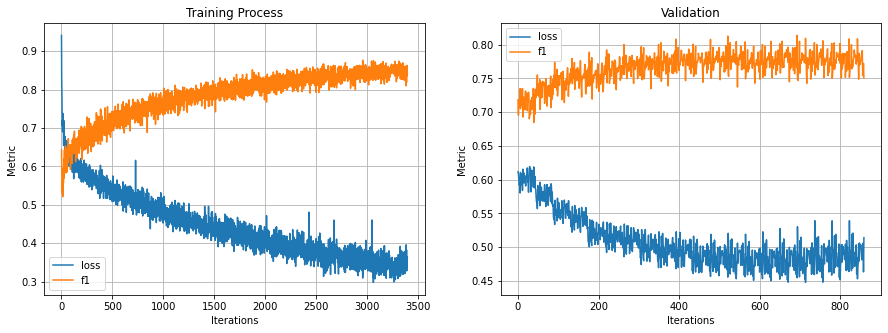

In [49]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

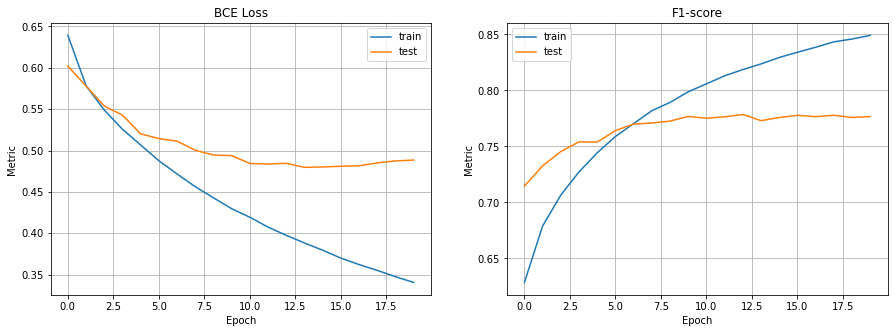

In [50]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Вот это было точно лишнее, похоже, что опять пошло переобучение. Посмотрим на метрики.

In [51]:
print(
    'CNN с dropout, нормализацией и emb_size=100: loss = {}, f1 = {}'.format(
        initial_cnn2_loss, initial_cnn2_f1))

initial_cnn4_loss = np.mean(losses_eval[-1])
initial_cnn4_f1 = np.mean(f1s_eval[-1])
print(
    'CNN с dropout\'ом и размером эмбеддинга 200: loss = {}, f1 = {}'.format(
        initial_cnn4_loss, initial_cnn4_f1))

CNN с dropout, нормализацией и emb_size=100: loss = 0.48438102769297225, f1 = 0.7777900099754333
CNN с dropout'ом и размером эмбеддинга 200: loss = 0.4884526403837426, f1 = 0.7766751050949097


Качество практически одинаковое (у последней модели даже чуть хуже), так что смысла брать эмбеддинги большего размера нет, оставляем 100.

### CNN-модель с предобученными эмбеддингами
Попробуем взять улучшенную модель и добавить предобученные эмбеддинги.

#### Обучение Fasttext-эмбеддингов
Поскольку слова в модели не лемматизированы, смысла использовать готовые модели нет, лучше обучить свою.

In [52]:
from gensim.models import FastText

In [53]:
texts_for_fasttext = [' '.join(t) for t in tweets['tokens'].tolist()]

ft = FastText(texts_for_fasttext, vector_size=100, window=5, min_count=1)

In [54]:
weights = np.zeros((len(token2id), 100))

count = 0
for token, i in token2id.items():
    if token == 'PAD':
        continue
    try:
        weights[i] = ft.wv[token]
    except KeyError:
        count += 1
        weights[i] = np.random.normal(0, 0.1, 100)

In [55]:
ft_model = CNN2(len(token2id), 100, weights)
optimizer = optim.Adam(ft_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

ft_model = ft_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [56]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ft_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.723382434424232, Train f1: 0.5683730840682983
Train loss: 0.6932606644490186, Train f1: 0.586320698261261
Train loss: 0.675818054115071, Train f1: 0.5959157943725586
Train loss: 0.6640004318426637, Train f1: 0.6027473211288452
Train loss: 0.6558131677262923, Train f1: 0.6090478301048279

Validating...

Val loss: 0.6134677305817604, Val f1: 0.7054829597473145
Val loss: 0.6137561500072479, Val f1: 0.7032191753387451
Val loss: 0.6141259744763374, Val f1: 0.7045372128486633
Val loss: 0.6145521085709333, Val f1: 0.7044057846069336
Val loss: 0.6142236158251763, Val f1: 0.7053438425064087

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6106816004304325, Train f1: 0.643197774887085
Train loss: 0.605392155401847, Train f1: 0.6457757353782654
Train loss: 0.6034400030678394, Train f1: 0.6489839553833008
Train loss: 0.5999062898404458, Train f1: 0.6532015204429626
Train loss: 0.5986466884613038, Train f1: 0.6555209755897522

Validating...

Val loss: 0.5986297428607941, Val f1: 0.7183331251144409
Val loss: 0.599084347486496, Val f1: 0.7179868221282959
Val loss: 0.5997589553395907, Val f1: 0.718039333820343
Val loss: 0.6004268191754818, Val f1: 0.7173750400543213
Val loss: 0.6002800688147545, Val f1: 0.7178583145141602

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5799115230055416, Train f1: 0.6716604232788086
Train loss: 0.5789689263876747, Train f1: 0.6773022413253784
Train loss: 0.5770498163559857, Train f1: 0.6808192133903503
Train loss: 0.5760289759320372, Train f1: 0.6818274855613708
Train loss: 0.5745406617136563, Train f1: 0.6821098923683167

Validating...

Val loss: 0.5730501040816307, Val f1: 0.7299041152000427
Val loss: 0.5737779699265957, Val f1: 0.7277542948722839
Val loss: 0.5742161000768343, Val f1: 0.7283009886741638
Val loss: 0.574462004005909, Val f1: 0.7267762422561646
Val loss: 0.5745682403445244, Val f1: 0.7277697920799255

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5618010899599861, Train f1: 0.6941177845001221
Train loss: 0.5593324303627014, Train f1: 0.6953100562095642
Train loss: 0.5557212496505064, Train f1: 0.6974557042121887
Train loss: 0.553792268037796, Train f1: 0.7008398771286011
Train loss: 0.5532583096448113, Train f1: 0.7018510699272156

Validating...

Val loss: 0.5617753490805626, Val f1: 0.7399956583976746
Val loss: 0.5623720027506351, Val f1: 0.7372397184371948
Val loss: 0.5629602645834287, Val f1: 0.7377881407737732
Val loss: 0.5629700999706984, Val f1: 0.7367514371871948
Val loss: 0.5634057447314262, Val f1: 0.7376793026924133

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5411754250526428, Train f1: 0.7162504196166992
Train loss: 0.5388315390138065, Train f1: 0.714219868183136
Train loss: 0.5371979767200994, Train f1: 0.71503746509552
Train loss: 0.5368241764166776, Train f1: 0.7163283824920654
Train loss: 0.5355150531320011, Train f1: 0.7184053063392639

Validating...

Val loss: 0.5566079244017601, Val f1: 0.7458516955375671
Val loss: 0.5570481456816196, Val f1: 0.7439440488815308
Val loss: 0.5572573070724806, Val f1: 0.7449648380279541
Val loss: 0.5571787972003222, Val f1: 0.7442561984062195
Val loss: 0.5575107365846634, Val f1: 0.7444750070571899

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5235757810228011, Train f1: 0.7305526733398438
Train loss: 0.5230880896834766, Train f1: 0.7287993431091309
Train loss: 0.5234011382448907, Train f1: 0.7285534739494324
Train loss: 0.5216326321310857, Train f1: 0.7292858362197876
Train loss: 0.520889181249282, Train f1: 0.731574296951294

Validating...

Val loss: 0.5379900559782982, Val f1: 0.7534610033035278
Val loss: 0.5387690588831902, Val f1: 0.7517679929733276
Val loss: 0.5390442758798599, Val f1: 0.7517077326774597
Val loss: 0.538600318133831, Val f1: 0.7504174709320068
Val loss: 0.5391720399260521, Val f1: 0.7503700256347656

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5080973917947096, Train f1: 0.7436290979385376
Train loss: 0.5069951958516065, Train f1: 0.7429273128509521
Train loss: 0.5068989144820794, Train f1: 0.743463397026062
Train loss: 0.5056129512103165, Train f1: 0.7446295619010925
Train loss: 0.5051431587513755, Train f1: 0.7453070878982544

Validating...

Val loss: 0.5286280363798141, Val f1: 0.7581945657730103
Val loss: 0.5289761014282703, Val f1: 0.7569332718849182
Val loss: 0.5293572967251142, Val f1: 0.7572786211967468
Val loss: 0.5287155471742153, Val f1: 0.7561863660812378
Val loss: 0.5291956648230552, Val f1: 0.7562007904052734

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4957929735674578, Train f1: 0.7512001991271973
Train loss: 0.495544874931083, Train f1: 0.7514151334762573
Train loss: 0.49426957585063636, Train f1: 0.753020167350769
Train loss: 0.49360087842625733, Train f1: 0.7538970112800598
Train loss: 0.4920782259281944, Train f1: 0.7546554803848267

Validating...

Val loss: 0.5239643603563309, Val f1: 0.7620762586593628
Val loss: 0.5249109826982021, Val f1: 0.7603551149368286
Val loss: 0.5249925553798676, Val f1: 0.76125568151474
Val loss: 0.5243253707885742, Val f1: 0.7602123618125916
Val loss: 0.5249528110027313, Val f1: 0.7598398923873901

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4803612030604306, Train f1: 0.7619341015815735
Train loss: 0.48036818425444994, Train f1: 0.7635517716407776
Train loss: 0.479765611244183, Train f1: 0.7642760872840881
Train loss: 0.4786164350807667, Train f1: 0.7649065852165222
Train loss: 0.4793637710459092, Train f1: 0.7644569873809814

Validating...

Val loss: 0.5149057246744633, Val f1: 0.764819860458374
Val loss: 0.5159953664988279, Val f1: 0.7637584805488586
Val loss: 0.5160143499573072, Val f1: 0.7646667957305908
Val loss: 0.5152228735387325, Val f1: 0.7638322710990906
Val loss: 0.5159312427043915, Val f1: 0.762897789478302

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46400754591997934, Train f1: 0.773515522480011
Train loss: 0.46602190066786375, Train f1: 0.773003339767456
Train loss: 0.4684365958559747, Train f1: 0.7718484401702881
Train loss: 0.46826084045802846, Train f1: 0.7718082070350647
Train loss: 0.46811236371012294, Train f1: 0.7726307511329651

Validating...

Val loss: 0.507595855742693, Val f1: 0.7712610960006714
Val loss: 0.508358733728528, Val f1: 0.7694271802902222
Val loss: 0.5081255920231342, Val f1: 0.7688297629356384
Val loss: 0.5069646975025535, Val f1: 0.7673078775405884
Val loss: 0.5077320612967015, Val f1: 0.7665730714797974

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.45755268107442293, Train f1: 0.7821497917175293
Train loss: 0.46035759545424404, Train f1: 0.7804651260375977
Train loss: 0.4596876031627842, Train f1: 0.7798131108283997
Train loss: 0.45820144914528904, Train f1: 0.7800692915916443
Train loss: 0.4576680330669179, Train f1: 0.7803856134414673

Validating...

Val loss: 0.5035272017121315, Val f1: 0.7737133502960205
Val loss: 0.504371652379632, Val f1: 0.7705308198928833
Val loss: 0.5042876961330572, Val f1: 0.7700026631355286
Val loss: 0.5031723035499454, Val f1: 0.768993616104126
Val loss: 0.5039924778044224, Val f1: 0.7680680155754089

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.44344716825905967, Train f1: 0.7931270003318787
Train loss: 0.44809376404565926, Train f1: 0.7880516052246094
Train loss: 0.4485006411285961, Train f1: 0.7867255806922913
Train loss: 0.44806603188900385, Train f1: 0.7870573401451111
Train loss: 0.4483508942758336, Train f1: 0.786835253238678

Validating...

Val loss: 0.4974827282130718, Val f1: 0.7731054425239563
Val loss: 0.4984665997326374, Val f1: 0.7714834809303284
Val loss: 0.4983265623450279, Val f1: 0.7710006833076477
Val loss: 0.4971941336989403, Val f1: 0.7702038288116455
Val loss: 0.4979036711156368, Val f1: 0.7694032192230225

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.43265976888291974, Train f1: 0.795819878578186
Train loss: 0.43569061116260643, Train f1: 0.7953063249588013
Train loss: 0.43785229734345976, Train f1: 0.7945384383201599
Train loss: 0.43902596524533105, Train f1: 0.7923053503036499
Train loss: 0.43917392124147975, Train f1: 0.7926211953163147

Validating...

Val loss: 0.4963166266679764, Val f1: 0.7749466896057129
Val loss: 0.49728973023593426, Val f1: 0.7727445363998413
Val loss: 0.4967832875748475, Val f1: 0.7730967402458191
Val loss: 0.49544007144868374, Val f1: 0.773368775844574
Val loss: 0.49623859152197836, Val f1: 0.7730499505996704

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4286612403743407, Train f1: 0.7997536659240723
Train loss: 0.42764993581701727, Train f1: 0.7989994287490845
Train loss: 0.4288850900004892, Train f1: 0.7995271682739258
Train loss: 0.42964133686002565, Train f1: 0.8000487089157104
Train loss: 0.429143352894222, Train f1: 0.7995397448539734

Validating...

Val loss: 0.49150386080145836, Val f1: 0.7766226530075073
Val loss: 0.492438355460763, Val f1: 0.7752355337142944
Val loss: 0.4921606120963891, Val f1: 0.775357723236084
Val loss: 0.49087433237582445, Val f1: 0.7747390270233154
Val loss: 0.49177046194672586, Val f1: 0.7736552953720093

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.422945557271733, Train f1: 0.8038221001625061
Train loss: 0.4198027055929689, Train f1: 0.8047876954078674
Train loss: 0.41989663184857834, Train f1: 0.8052816987037659
Train loss: 0.421044536811464, Train f1: 0.8044841885566711
Train loss: 0.42184789619025065, Train f1: 0.8038181066513062

Validating...

Val loss: 0.4929443635046482, Val f1: 0.781125009059906
Val loss: 0.4937241952866316, Val f1: 0.7784978747367859
Val loss: 0.49334752435485524, Val f1: 0.7773855328559875
Val loss: 0.4919086657464504, Val f1: 0.7769336700439453
Val loss: 0.49286382645368576, Val f1: 0.7760373950004578

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4068292449502384, Train f1: 0.8155675530433655
Train loss: 0.4099478625199374, Train f1: 0.8116378784179688
Train loss: 0.4111451509536481, Train f1: 0.8104632496833801
Train loss: 0.41336964969249335, Train f1: 0.808597207069397
Train loss: 0.413827642623116, Train f1: 0.8086866736412048

Validating...

Val loss: 0.48733965307474136, Val f1: 0.7791503071784973
Val loss: 0.48820995166897774, Val f1: 0.77681565284729
Val loss: 0.48794322833418846, Val f1: 0.7758455276489258
Val loss: 0.48630485590547323, Val f1: 0.7750363349914551
Val loss: 0.48709541037678716, Val f1: 0.7738205194473267

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.40162712598548217, Train f1: 0.8175577521324158
Train loss: 0.40158115809454636, Train f1: 0.8153238296508789
Train loss: 0.4029817703892203, Train f1: 0.813448429107666
Train loss: 0.4051697414149256, Train f1: 0.812917172908783
Train loss: 0.4062156649196849, Train f1: 0.8127667307853699

Validating...

Val loss: 0.4876728989183903, Val f1: 0.7780327796936035
Val loss: 0.4879177715629339, Val f1: 0.7757962942123413
Val loss: 0.48737792546550435, Val f1: 0.7749951481819153
Val loss: 0.48605746030807495, Val f1: 0.7736542224884033
Val loss: 0.4866778805851936, Val f1: 0.773051917552948

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3981424456133562, Train f1: 0.8187053799629211
Train loss: 0.3985758081955068, Train f1: 0.817791223526001
Train loss: 0.3987526116417904, Train f1: 0.8174446225166321
Train loss: 0.39872492104768753, Train f1: 0.8178545832633972
Train loss: 0.3998465750147315, Train f1: 0.8173366785049438

Validating...

Val loss: 0.4858798086643219, Val f1: 0.7782459855079651
Val loss: 0.4870066326111555, Val f1: 0.7772654294967651
Val loss: 0.4867692068219185, Val f1: 0.7765697836875916
Val loss: 0.4849823182448745, Val f1: 0.776167631149292
Val loss: 0.4857404887676239, Val f1: 0.7755209803581238

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.38729088709634896, Train f1: 0.825991690158844
Train loss: 0.3885973003857276, Train f1: 0.8250130414962769
Train loss: 0.39019907075984805, Train f1: 0.8227357864379883
Train loss: 0.3926602632683866, Train f1: 0.8211398124694824
Train loss: 0.3933892928502139, Train f1: 0.8208776116371155

Validating...

Val loss: 0.4865434728562832, Val f1: 0.7816416025161743
Val loss: 0.4869320970028639, Val f1: 0.7800283432006836
Val loss: 0.4867747413615386, Val f1: 0.7786500453948975
Val loss: 0.48508189991116524, Val f1: 0.7779542803764343
Val loss: 0.4859317049384117, Val f1: 0.7767452001571655

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3825892359018326, Train f1: 0.8296475410461426
Train loss: 0.38176289113128886, Train f1: 0.8297443389892578
Train loss: 0.3844945798901951, Train f1: 0.8266075253486633
Train loss: 0.38486117913442497, Train f1: 0.8264732956886292
Train loss: 0.3869684399927364, Train f1: 0.8247448801994324

Validating...

Val loss: 0.48556938767433167, Val f1: 0.77869713306427
Val loss: 0.48651568219065666, Val f1: 0.7795525789260864
Val loss: 0.48666250333189964, Val f1: 0.7779450416564941
Val loss: 0.48490453325212, Val f1: 0.777726411819458
Val loss: 0.48596441820263864, Val f1: 0.7766129374504089


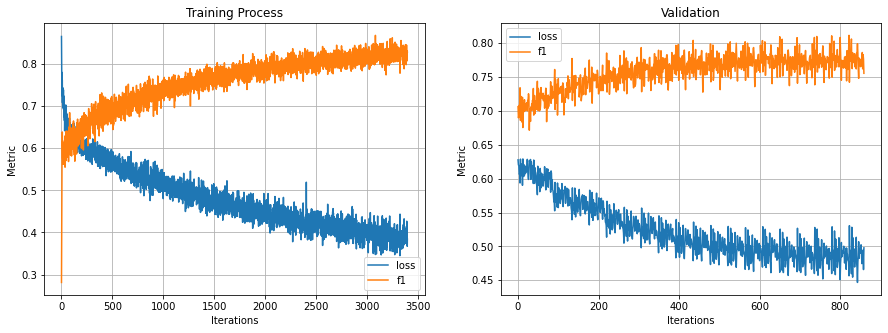

In [57]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

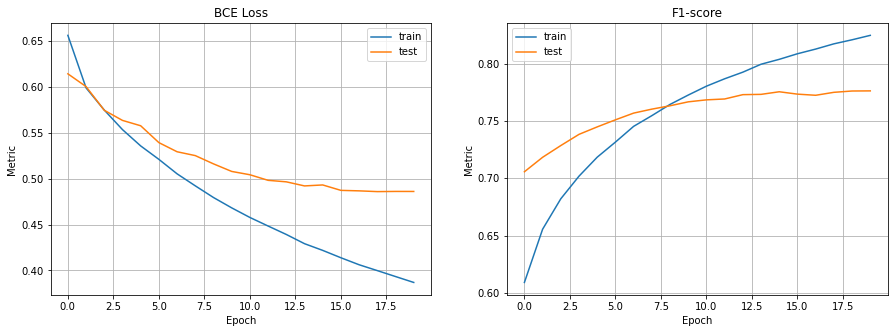

In [58]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

In [59]:
print(
    'CNN без FastText (dropout, нормализация, emb_size=100): \
loss = {}, f1 = {}'.format(initial_cnn2_loss, initial_cnn2_f1))

initial_cnn_ft_loss = np.mean(losses_eval[-1])
initial_cnn_ft_f1 = np.mean(f1s_eval[-1])
print(
    'CNN с FastText (dropout, нормализация, emb_size=100): \
loss = {}, f1 = {}'.format(
        initial_cnn_ft_loss, initial_cnn_ft_f1))

CNN без FastText (dropout, нормализация, emb_size=100): loss = 0.48438102769297225, f1 = 0.7777900099754333
CNN с FastText (dropout, нормализация, emb_size=100): loss = 0.48597234556841296, f1 = 0.7762707471847534


Получилось практически одинаково, даже чуть хуже :( Еще эмбеддинги FastText'а, видимо, по-разному обучаются, несмотря на фиксацию всех сидов в самом начале, потому что я четыре раза перезапускала и все время были разные результаты (то чуть лучше, то чуть хуже модели без фасттекста, но в пределах 0.01).

Сравним теперь с изначальными результатами.

In [60]:
print(
    'CNN без FastText-эмбеддингов до улучшений: loss = {}, f1 = {}'.format(
        initial_cnn_loss, initial_cnn_f1))
print(
    'CNN с FastText (dropout, нормализация, emb_size=100): \
loss = {}, f1 = {}'.format(
        initial_cnn_ft_loss, initial_cnn_ft_f1))

CNN без FastText-эмбеддингов до улучшений: loss = 0.6815855724867, f1 = 0.7562121152877808
CNN с FastText (dropout, нормализация, emb_size=100): loss = 0.48597234556841296, f1 = 0.7762707471847534


Последняя модель в этой части -- все то же самое, но с 15 эпохами.

In [61]:
ft2_model = CNN2(len(token2id), 100, weights)
optimizer = optim.Adam(ft2_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

ft2_model = ft2_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [62]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ft2_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=15)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7192252699066611, Train f1: 0.5705417394638062
Train loss: 0.6928550443228554, Train f1: 0.5871196985244751
Train loss: 0.674810553298277, Train f1: 0.597165584564209
Train loss: 0.6626533528461176, Train f1: 0.6051844358444214
Train loss: 0.6529653756057515, Train f1: 0.6120874881744385

Validating...

Val loss: 0.6415327936410904, Val f1: 0.6972650289535522
Val loss: 0.643024705350399, Val f1: 0.6978715658187866
Val loss: 0.6433933277924856, Val f1: 0.6978941559791565
Val loss: 0.6440371423959732, Val f1: 0.697944700717926
Val loss: 0.643818998336792, Val f1: 0.6990693211555481

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6062362158999723, Train f1: 0.6471853852272034
Train loss: 0.6048046078752068, Train f1: 0.651542603969574
Train loss: 0.60230952501297, Train f1: 0.653234601020813
Train loss: 0.5997363149243242, Train f1: 0.6556419134140015
Train loss: 0.5983113222262438, Train f1: 0.6575137972831726

Validating...

Val loss: 0.6102803722023964, Val f1: 0.7147596478462219
Val loss: 0.6114425361156464, Val f1: 0.7136720418930054
Val loss: 0.6111922065416971, Val f1: 0.71524977684021
Val loss: 0.6118274834007025, Val f1: 0.7150757312774658
Val loss: 0.6117520377039909, Val f1: 0.7158774137496948

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5827580900753245, Train f1: 0.6742187142372131
Train loss: 0.5797988684738383, Train f1: 0.6788457632064819
Train loss: 0.5770465486189899, Train f1: 0.6807239651679993
Train loss: 0.575577177983873, Train f1: 0.6815254092216492
Train loss: 0.5743983927895041, Train f1: 0.682589590549469

Validating...

Val loss: 0.5906633958220482, Val f1: 0.7278059720993042
Val loss: 0.5915404856204987, Val f1: 0.7278939485549927
Val loss: 0.5910684367020925, Val f1: 0.7282492518424988
Val loss: 0.591739634051919, Val f1: 0.7279874086380005
Val loss: 0.5919089108705521, Val f1: 0.727901816368103

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5550246606854832, Train f1: 0.7014268040657043
Train loss: 0.5561059476698146, Train f1: 0.7015033960342407
Train loss: 0.5553794374652937, Train f1: 0.7029808163642883
Train loss: 0.5549075651694747, Train f1: 0.7024492621421814
Train loss: 0.5535692484939799, Train f1: 0.7035096287727356

Validating...

Val loss: 0.5744651630520821, Val f1: 0.7385464310646057
Val loss: 0.5754255875945091, Val f1: 0.7374734878540039
Val loss: 0.5746310626467069, Val f1: 0.7382522225379944
Val loss: 0.5751462206244469, Val f1: 0.7378708124160767
Val loss: 0.5756466180086136, Val f1: 0.7380320429801941

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.537899268024108, Train f1: 0.7200113534927368
Train loss: 0.5375927616568172, Train f1: 0.7180474400520325
Train loss: 0.5370830531213798, Train f1: 0.7204983830451965
Train loss: 0.5349637344479561, Train f1: 0.7206864953041077
Train loss: 0.5335303019074833, Train f1: 0.7211951017379761

Validating...

Val loss: 0.5578948259353638, Val f1: 0.7466334700584412
Val loss: 0.5587501190602779, Val f1: 0.7451478242874146
Val loss: 0.5575178861618042, Val f1: 0.7458155751228333
Val loss: 0.5575807355344296, Val f1: 0.7457985877990723
Val loss: 0.5581949919462204, Val f1: 0.7463151216506958

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5198124235167223, Train f1: 0.7324400544166565
Train loss: 0.5190173628575662, Train f1: 0.73414546251297
Train loss: 0.5184884921592825, Train f1: 0.7351560592651367
Train loss: 0.5188290301491233, Train f1: 0.7344433069229126
Train loss: 0.5179257573450313, Train f1: 0.734466016292572

Validating...

Val loss: 0.5458086058497429, Val f1: 0.7535291314125061
Val loss: 0.5469142086803913, Val f1: 0.7519023418426514
Val loss: 0.5461373676856359, Val f1: 0.7532404065132141
Val loss: 0.5460280366241932, Val f1: 0.7533660531044006
Val loss: 0.5469296991825103, Val f1: 0.7536472678184509

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5041055223521065, Train f1: 0.745795726776123
Train loss: 0.5041600062566645, Train f1: 0.748736560344696
Train loss: 0.5029029968906852, Train f1: 0.748099148273468
Train loss: 0.5026467606863555, Train f1: 0.7472875714302063
Train loss: 0.5023886670084561, Train f1: 0.7468186020851135

Validating...

Val loss: 0.5344640240073204, Val f1: 0.7564953565597534
Val loss: 0.5354631133377552, Val f1: 0.7563821077346802
Val loss: 0.5345734978715578, Val f1: 0.759169340133667
Val loss: 0.5343929249793291, Val f1: 0.7596547603607178
Val loss: 0.5353520259261131, Val f1: 0.7597022652626038

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4895208206246881, Train f1: 0.7552631497383118
Train loss: 0.48779117885757894, Train f1: 0.7573935985565186
Train loss: 0.4893447946684033, Train f1: 0.7581171989440918
Train loss: 0.4892904824193786, Train f1: 0.7585484385490417
Train loss: 0.48840659278280596, Train f1: 0.7583465576171875

Validating...

Val loss: 0.526833176612854, Val f1: 0.7605622410774231
Val loss: 0.5275979191064835, Val f1: 0.7608895301818848
Val loss: 0.5266336550315222, Val f1: 0.7631614804267883
Val loss: 0.5261781178414822, Val f1: 0.7637162208557129
Val loss: 0.5271546259522438, Val f1: 0.7637222409248352

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4770473268102197, Train f1: 0.7669482827186584
Train loss: 0.47930968596654777, Train f1: 0.7658436894416809
Train loss: 0.47951081716546823, Train f1: 0.7656890749931335
Train loss: 0.4786076859077987, Train f1: 0.7665567994117737
Train loss: 0.47698172979495107, Train f1: 0.7668890357017517

Validating...

Val loss: 0.5166386291384697, Val f1: 0.7638790607452393
Val loss: 0.5172406770288944, Val f1: 0.7653242945671082
Val loss: 0.5165448598563671, Val f1: 0.7688576579093933
Val loss: 0.5161598352715373, Val f1: 0.769199550151825
Val loss: 0.5171574525535106, Val f1: 0.7691518068313599

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4665641565533245, Train f1: 0.7739070653915405
Train loss: 0.46490416631979103, Train f1: 0.7758684754371643
Train loss: 0.4658403647880928, Train f1: 0.7755910754203796
Train loss: 0.4656390964108355, Train f1: 0.7753725051879883
Train loss: 0.4655552494175294, Train f1: 0.7755466103553772

Validating...

Val loss: 0.5123312808573246, Val f1: 0.7651129961013794
Val loss: 0.5131519958376884, Val f1: 0.7665930986404419
Val loss: 0.5121639793117841, Val f1: 0.7699615359306335
Val loss: 0.511681541800499, Val f1: 0.7705519199371338
Val loss: 0.5128084883093834, Val f1: 0.7703779339790344

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4581241248285069, Train f1: 0.7810915112495422
Train loss: 0.45632725296651616, Train f1: 0.7808884382247925
Train loss: 0.45542020511393455, Train f1: 0.7819978594779968
Train loss: 0.4552699171883218, Train f1: 0.7827048897743225
Train loss: 0.45466739132123835, Train f1: 0.7832272052764893

Validating...

Val loss: 0.5032358206808567, Val f1: 0.7673021554946899
Val loss: 0.5042517799884081, Val f1: 0.7690037488937378
Val loss: 0.5033677133421103, Val f1: 0.7719020843505859
Val loss: 0.50252974499017, Val f1: 0.7728959321975708
Val loss: 0.503921815007925, Val f1: 0.7728609442710876

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4425803922555026, Train f1: 0.7891572117805481
Train loss: 0.44240786441985297, Train f1: 0.7913774251937866
Train loss: 0.44423482669334785, Train f1: 0.7892967462539673
Train loss: 0.44608930827063675, Train f1: 0.788307785987854
Train loss: 0.4454222549410427, Train f1: 0.788928210735321

Validating...

Val loss: 0.5056027583777905, Val f1: 0.7697798013687134
Val loss: 0.5066120252013206, Val f1: 0.771187424659729
Val loss: 0.5056183102230231, Val f1: 0.7741446495056152
Val loss: 0.5047048768028617, Val f1: 0.7752037644386292
Val loss: 0.5061194531619548, Val f1: 0.774774432182312

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4382729083299637, Train f1: 0.7969347834587097
Train loss: 0.4371400808586794, Train f1: 0.7965402603149414
Train loss: 0.43751507325499667, Train f1: 0.7959745526313782
Train loss: 0.43759485158850164, Train f1: 0.795398473739624
Train loss: 0.4372372599209056, Train f1: 0.7949764728546143

Validating...

Val loss: 0.49718303605914116, Val f1: 0.7715673446655273
Val loss: 0.49796364456415176, Val f1: 0.7736576795578003
Val loss: 0.49713486433029175, Val f1: 0.7765447497367859
Val loss: 0.49608125630766153, Val f1: 0.7773151397705078
Val loss: 0.49755507707595825, Val f1: 0.7767212986946106

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4287143621374579, Train f1: 0.8008667230606079
Train loss: 0.4305260010501918, Train f1: 0.799249529838562
Train loss: 0.4309120683693418, Train f1: 0.7981544733047485
Train loss: 0.42975965186077003, Train f1: 0.7983144521713257
Train loss: 0.4283329378156101, Train f1: 0.799312174320221

Validating...

Val loss: 0.48890426754951477, Val f1: 0.7745937705039978
Val loss: 0.4899342581629753, Val f1: 0.7743552923202515
Val loss: 0.4890458782513936, Val f1: 0.7771555781364441
Val loss: 0.48778651654720306, Val f1: 0.777572751045227
Val loss: 0.48917835354804995, Val f1: 0.7770949006080627

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.41929534428259907, Train f1: 0.8051886558532715
Train loss: 0.42016828323111816, Train f1: 0.8037325143814087
Train loss: 0.4206346746753244, Train f1: 0.8034453988075256
Train loss: 0.41951336952693324, Train f1: 0.8045850992202759
Train loss: 0.41940127733875726, Train f1: 0.8057196140289307

Validating...

Val loss: 0.4949982203543186, Val f1: 0.7758849859237671
Val loss: 0.49576572701334953, Val f1: 0.7776833176612854
Val loss: 0.49517298862338066, Val f1: 0.78009033203125
Val loss: 0.4940397972241044, Val f1: 0.7800098657608032
Val loss: 0.49585376083850863, Val f1: 0.7792946696281433


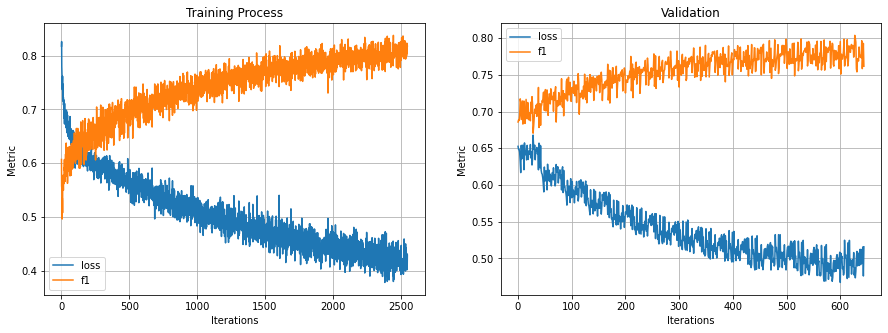

In [63]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

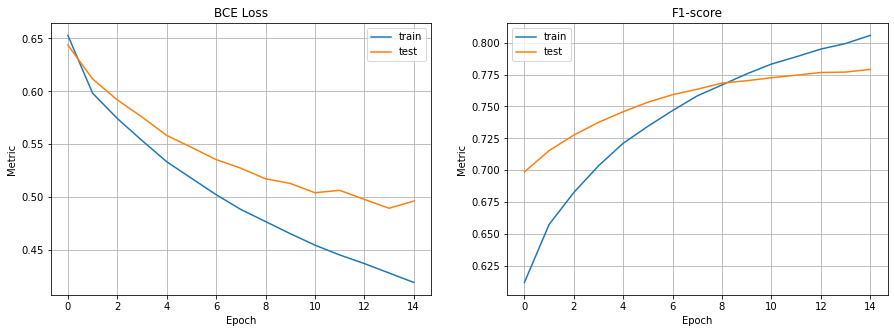

In [64]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

In [65]:
print(
    'CNN с FastText (dropout, нормализация, emb_size=100, 20 эпох): \
loss = {}, f1 = {}'.format(
        initial_cnn_ft_loss, initial_cnn_ft_f1))

initial_cnn_ft15_loss = np.mean(losses_eval[-1])
initial_cnn_ft15_f1 = np.mean(f1s_eval[-1])
print(
    'CNN с FastText (dropout, нормализация, emb_size=100, 15 эпох): \
loss = {}, f1 = {}'.format(
        initial_cnn_ft15_loss, initial_cnn_ft15_f1))

CNN с FastText (dropout, нормализация, emb_size=100, 20 эпох): loss = 0.48597234556841296, f1 = 0.7762707471847534
CNN с FastText (dropout, нормализация, emb_size=100, 15 эпох): loss = 0.49631304934967396, f1 = 0.7790654897689819


Примерно одно и то же, так что можно не мучиться и не ждать пять лишних эпох. Теперь сравним исходную модель с изначальной.

In [74]:
print(
    'Исходная модель (CNN без FastText-эмбеддингов, 20 эпох): \
loss = {}, f1 = {}'.format(initial_cnn_loss, initial_cnn_f1))

print(
    'Финальная модель (CNN с FastText + dropout и нормализация, \
15 эпох): loss = {}, f1 = {}'.format(
        initial_cnn_ft15_loss, initial_cnn_ft15_f1))

Исходная модель (CNN без FastText-эмбеддингов, 20 эпох): loss = 0.6815855724867, f1 = 0.7562121152877808
Финальная модель (CNN с FastText + dropout и нормализация, 15 эпох): loss = 0.49631304934967396, f1 = 0.7790654897689819


### Оценка модели

In [66]:
def predict_and_evaluate(model, iterator):

    model.eval()
    fp, fn, tp, tn = [], [], [], []

    progress_bar = tqdm(total=len(iterator.dataset))

    with torch.no_grad():

        for i, (texts, ys) in enumerate(iterator):

            preds = model(texts)  # делаем предсказания на тесте

            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2token[int(token)]
                                 for token in text if token != 0])

                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)

                progress_bar.update()

    progress_bar.close()

    return fp, fn, tp, tn

In [67]:
fp, fn, tp, tn = predict_and_evaluate(ft_model, val_iterator)

  0%|          | 0/43488 [00:00<?, ?it/s]

#### Accuracy, precision, recall

In [73]:
accuracy = (len(tp) + len(tn)) / (len(tp) + len(fp) + len(tn) + len(fn))
precision = len(tp) / (len(tp) + len(fp))
recall = len(tp) / (len(tp) + len(fn))
f1 = 2 * precision * recall / (precision + recall)

print(
    'Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}'.format(
        accuracy, precision, recall, f1))

Accuracy: 0.7574733259749816
Precision: 0.7293008828441899
Recall: 0.830608270302097
F1: 0.7766649020645845


#### Confusion matrix

In [68]:
cf_matrix = [[len(tn), len(fp)],
             [len(fn), len(tp)]]
cf_matrix

[[14602, 6807], [3740, 18339]]

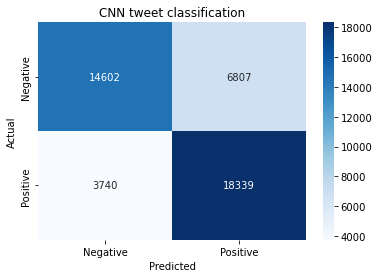

In [69]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('CNN tweet classification')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

#### Анализ ошибок

In [70]:
def analize_results(fp, fn, tp, tn):
    print('\nВерно распознаны как отрицательные:\n')
    print('\n'.join(random.sample(tn, 10)))
    print('\nЛожно распознаны как отрицательные:\n')
    print('\n'.join(random.sample(fn, 10)))
    print('\nВерно распознаны как положительные:\n')
    print('\n'.join(random.sample(tp, 10)))
    print('\nЛожно распознаны как положительные:\n')
    print('\n'.join(random.sample(fp, 10)))

In [71]:
analize_results(fp, fn, tp, tn)


Верно распознаны как отрицательные:

USER сессия еще хуже удачи тебе
и снова кофе и энергетик бессонная ночь вторую неделю и именно с субботы на воскресенье когда мне к 9 на работу
я думала что посплю завтра а мне еще выступать на студии не хочу
USER USER бля там короче их 6 штук середины нет
26 рядом нет не биатлон
как волчков это все голос
пипец с самого утра начала болеть нога ааааа
USER тоесть нытье о сессии тебе дороже меня
USER тока с твитами у миня беда
надо было вчера в школу пойти а сегодня нет не к а она вещь говорила

Ложно распознаны как отрицательные:

в и без и в
USER USER по опять тупит и дает старые фото
одноклассники вы все решили сойти с ума и зарегаться в твиттере вы ж говорили что это хуйня
фак 1 вечера а меня убрать попросили пизд вовремя
у гаги куча грэмми у перри ни одной сасайте лалки все куплено у нет вкуса музыка не для всех
USER я седня видела его в списке топ 1 какой он нафиг
USER уже прекратила у нас дефицит
23 февраля отмечают до 8 марта а 8 марта должно 

Среди неверное классифицированных твитов присутствуют как очевидные ошибки, так и твиты, которым даже человеческому аннотатору трудно приписать оценку. Поскольку модель опираются только на слова, ей может быть трудно понять, к какому классу относится твит, если содержащиеся в нем слова не имеют четкой эмоциональной окрашенности (по-видимому, этим объясняется классификация негативных твитов со словами "спасибо", "удача" как положительных, а со словами "ужасно", "жесть" -- как отрицательных).

Общий вывод -- прежде чем требовать от модели идеальных результатов, нужно обучить ее на чистых данных. Как мы узнали, этот датасет собирался по смайликам, что привело к плохим результатам по двум причинам:
1. Смайлики != реальная эмоциональная окраска --> в датасете есть твиты с необоснованно приписанным классом --> модель запоминает неверную классификацию;
2. Смайлики -- очень весомый признак --> без них очень плохое качество.

Делать эксперимент с менее жестким препроцессингом и оставлением пунктуации я не стала, потому что многие уже это сделали и поняли, что качество сильно лучше.

P.S. Вторая модель в другой тетрадке, эту я устала листать))